In [1]:
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import svm, datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import PrecisionRecallDisplay

In [10]:
df_all = pd.read_csv('merge_journal_list_interesting_url_all_unique_normalizedname.csv')

In [11]:
df_all.shape

(19352, 10)

In [9]:
web_features1 = []
web_features0 = []
tmp = []

for batch in range(0,100):
    with open('./labeled_feature_data_local_html/web_content_features_1_'+str(batch)+'.pkl', 'rb') as f:
        web_features1 += pickle.load(f)
        

    with open('./labeled_feature_data_local_html/web_content_features_0_'+str(batch)+'.pkl', 'rb') as f:
        web_features0 += pickle.load(f)


print(len(web_features1)+len(web_features0))


web_features1 = [[ind]+ft for ind,ft in enumerate(web_features1) if len(ft) >9]



unwhite_tb = pd.DataFrame(web_features1)
unwhite_tb['label'] = 1


web_features0 = [[ind]+ft for ind,ft in enumerate(web_features0) if len(ft) >9]


white_tb = pd.DataFrame(web_features0)
white_tb['label'] = 0


all_tb = pd.concat([unwhite_tb,white_tb]).reset_index(drop=True)

X1 = all_tb.loc[:, all_tb.columns != 'label']
y1 = all_tb.loc[:, all_tb.columns == 'label']

19352


In [4]:
len(web_features1[0])

18

In [5]:
len(web_features0[0])

18

In [8]:
clf = RandomForestClassifier(max_depth=20,n_estimators = 500, random_state=0)

In [12]:
clf.fit(X1,y1)

<ipython-input-12-02e4c239c946>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X1,y1)


RandomForestClassifier(max_depth=20, n_estimators=500, random_state=0)

In [13]:
clf.feature_importances_

array([0.05339746, 0.04099378, 0.02234982, 0.05416652, 0.06656634,
       0.04416631, 0.05186088, 0.05810395, 0.04954916, 0.06243036,
       0.18732056, 0.1905198 , 0.02889845, 0.04245187, 0.01978851,
       0.02743622, 0.        ])

In [11]:
from sklearn import preprocessing

In [12]:
scaler = preprocessing.StandardScaler().fit(X1)

In [13]:
lr = LogisticRegression(random_state=0,max_iter=1000).fit(scaler.transform(X1), y1)

/home/hzhuang/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
lr.coef_

array([[-1.18471363e+00, -1.06148833e+00, -1.16068139e-01,
        -2.22754778e+00,  1.01279832e+00,  1.91115384e+00,
         2.15982063e-01,  9.09015043e-02, -1.09672241e+00,
        -1.46397612e-01,  2.89622438e-01,  5.56988925e-01,
        -2.63790491e-01, -3.66788067e-04,  1.07213730e-01,
        -9.18435751e-02,  0.00000000e+00]])

<ipython-input-10-33b90ae4a0ac>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X1.iloc[train], y1.iloc[train])
<ipython-input-10-33b90ae4a0ac>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X1.iloc[train], y1.iloc[train])
<ipython-input-10-33b90ae4a0ac>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X1.iloc[train], y1.iloc[train])
<ipython-input-10-33b90ae4a0ac>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X1.iloc[train], y1.iloc[train])
<ipython-input-10-33b90ae4a0ac>:12: Data

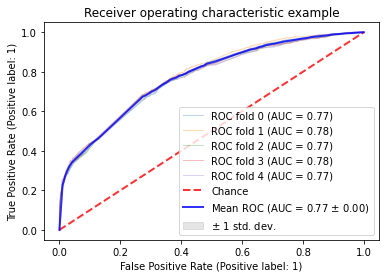

In [10]:
cv = StratifiedKFold(n_splits=5,random_state = 611,shuffle=True)
#classifier = svm.SVC( random_state=5)
#classifier = LogisticRegression(random_state=5)
#classifier = LogisticRegressionCV(random_state=5)
classifier = RandomForestClassifier(max_depth=20,n_estimators = 500, random_state=0)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X1, y1)):
    classifier.fit(X1.iloc[train], y1.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X1.iloc[test],
        y1.iloc[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()

In [11]:
np.std([0.77,0.78,0.77,0.78,0.77])

0.004898979485566361

<ipython-input-13-65b716861c46>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X1.iloc[train], y1.iloc[train])
<ipython-input-13-65b716861c46>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X1.iloc[train], y1.iloc[train])
<ipython-input-13-65b716861c46>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X1.iloc[train], y1.iloc[train])
<ipython-input-13-65b716861c46>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X1.iloc[train], y1.iloc[train])
<ipython-input-13-65b716861c46>:12: Data

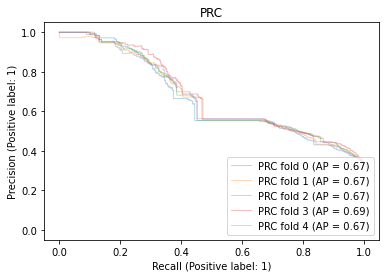

In [13]:
cv = StratifiedKFold(n_splits=5,random_state = 231,shuffle=True)
#classifier = svm.SVC( random_state=5)
#classifier = LogisticRegression(random_state=5)
#classifier = LogisticRegressionCV(random_state=5)
classifier = RandomForestClassifier(max_depth=20,n_estimators = 500, random_state=0,n_jobs=6)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X1, y1)):
    classifier.fit(X1.iloc[train], y1.iloc[train])
    viz = PrecisionRecallDisplay.from_estimator(
        classifier,
        X1.iloc[test],
        y1.iloc[test],
        name="PRC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    #interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    #interp_tpr[0] = 0.0
    #tprs.append(interp_tpr)
    #aucs.append(viz.roc_auc)



ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="PRC",
)
ax.legend(loc="lower right")
plt.show()

In [14]:
np.std([0.67,0.67,0.67,0.69,0.67])

0.007999999999999962

In [21]:
np.mean([0.67,0.67,0.67,0.69,0.67])

0.674

In [74]:
import numpy as np

In [75]:
abs_features1 = []
abs_features0 = []

for batch in range(100):
    with open('./labeled_feature_data_local_html/web_content_features_1_'+str(batch)+'_abs.pkl', 'rb') as f:
        tmp = pickle.load(f)
        #print(tmp)
        dt = [[tt for tt in t if len(tt) == 10] for t in tmp if len(t) >0 and len([tt for tt in t if len(tt)==10])]
        #print(dat)
        abs_features1 += [np.mean(np.array(t), axis=0) for t in dt]

    with open('./labeled_feature_data_local_html/web_content_features_0_'+str(batch)+'_abs.pkl', 'rb') as f:
        tmp = pickle.load(f)
        dt = [[tt for tt in t if len(tt) == 10] for t in tmp if len(t) >0 and len([tt for tt in t if len(tt)==10])]
        
        abs_features0 += [np.mean(np.array(t), axis=0) for t in dt]

#print('abstract feature')
#print(abs_features1)
#print(abs_features0)
#print(len(abs_features1))
#print(len(abs_features0))


#abs_features1 = [np.mean(np.array(ft), axis=0) for ft in abs_features1 if len([f for f in ft if len(f) == 10]) > 0]



unwhite_tb = pd.DataFrame(abs_features1)
unwhite_tb['label'] = 1

#abs_features0 = [np.mean(np.array(ft), axis=0) for ft in abs_features0 if len([f for f in ft if len(f) == 10]) > 0]


white_tb = pd.DataFrame(abs_features0)
white_tb['label'] = 0

#print(len(abs_features1))
#print(abs_features1)
#print(len(abs_features0))

all_tb = pd.concat([unwhite_tb,white_tb]).reset_index(drop=True)

X2 = all_tb.loc[:, all_tb.columns != 'label']
y2 = all_tb.loc[:, all_tb.columns == 'label']

In [76]:
clf = RandomForestClassifier(max_depth=20,n_estimators = 500, random_state=0)

In [77]:
clf.fit(X2,y2)

<ipython-input-77-e75bc7e5c6b5>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X2,y2)


RandomForestClassifier(max_depth=20, n_estimators=500, random_state=0)

In [78]:
clf.feature_importances_

array([0.0984185 , 0.09832792, 0.06987827, 0.09933977, 0.08572095,
       0.10394539, 0.10691568, 0.10336979, 0.12804754, 0.10603617])

In [79]:
scaler = preprocessing.StandardScaler().fit(X2)

In [80]:
lr = LogisticRegression(random_state=0,max_iter=1000).fit(scaler.transform(X2), y2)
lr.coef_

/home/hzhuang/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[ 0.88890851,  0.78880835, -0.49305328, -1.41029533, -0.00707696,
         1.56410904,  1.01404898, -0.13648495, -0.59147302, -1.11903746]])

<ipython-input-17-33b90ae4a0ac>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X1.iloc[train], y1.iloc[train])
<ipython-input-17-33b90ae4a0ac>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X1.iloc[train], y1.iloc[train])
<ipython-input-17-33b90ae4a0ac>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X1.iloc[train], y1.iloc[train])
<ipython-input-17-33b90ae4a0ac>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X1.iloc[train], y1.iloc[train])
<ipython-input-17-33b90ae4a0ac>:12: Data

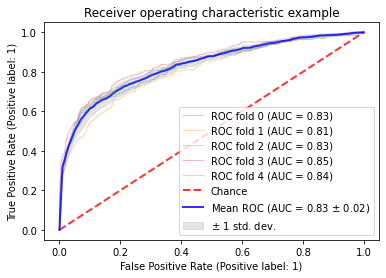

In [17]:
cv = StratifiedKFold(n_splits=5,random_state = 611,shuffle=True)
#classifier = svm.SVC( random_state=5)
#classifier = LogisticRegression(random_state=5)
#classifier = LogisticRegressionCV(random_state=5)
classifier = RandomForestClassifier(max_depth=20,n_estimators = 500, random_state=0)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X2, y2)):
    classifier.fit(X2.iloc[train], y2.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X2.iloc[test],
        y2.iloc[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()

<ipython-input-18-d4fcd02fdcb0>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X1.iloc[train], y1.iloc[train])
<ipython-input-18-d4fcd02fdcb0>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X1.iloc[train], y1.iloc[train])
<ipython-input-18-d4fcd02fdcb0>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X1.iloc[train], y1.iloc[train])
<ipython-input-18-d4fcd02fdcb0>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X1.iloc[train], y1.iloc[train])
<ipython-input-18-d4fcd02fdcb0>:12: Data

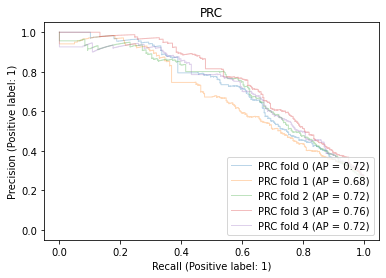

In [18]:
cv = StratifiedKFold(n_splits=5,random_state = 611,shuffle=True)
#classifier = svm.SVC( random_state=5)
#classifier = LogisticRegression(random_state=5)
#classifier = LogisticRegressionCV(random_state=5)
classifier = RandomForestClassifier(max_depth=20,n_estimators = 500, random_state=0,n_jobs=6)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X1, y1)):
    classifier.fit(X1.iloc[train], y1.iloc[train])
    viz = PrecisionRecallDisplay.from_estimator(
        classifier,
        X1.iloc[test],
        y1.iloc[test],
        name="PRC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    #interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    #interp_tpr[0] = 0.0
    #tprs.append(interp_tpr)
    #aucs.append(viz.roc_auc)



ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="PRC",
)
ax.legend(loc="lower right")
plt.show()

In [19]:
np.std([0.72,0.68,0.72,0.76,0.72])

0.02529822128134702

In [20]:
np.mean([0.72,0.68,0.72,0.76,0.72])

0.72

In [51]:
#drop two duplicated columns: save value but different column name
bibilometrics = pd.read_csv('labeled_journals_biblio_features_all.csv').drop(columns=['journal_paper_cited_num','journal_journal_reference_num'])

In [52]:
bibilometrics.columns

Index(['JournalId', 'NormalizedName', 'Issn', 'Reason',
       'num_journal_publication', 'num_journal_author',
       'num_journal_affiliation', 'journal_year_first_publish',
       'journal_avg_hindex', 'journal_avg_first_author_hindex',
       'journal_avg_last_author_hindex', 'journal_avg_middle_author_hindex',
       'total_num_journal_reference', 'total_num_journal_cited',
       'journal_paper_reference_num', 'journal_journal_cited_num',
       'journal_num_author_referenced', 'journal_num_author_cited',
       'journal_num_affiliation_referenced', 'journal_num_affiliation_cited',
       'journal_num_journal_self_reference',
       'journal_num_author_self_reference',
       'journal_num_affiliation_self_reference',
       'journal_num_journal_self_cited', 'journal_num_author_self_cited',
       'journal_num_affiliation_self_cited'],
      dtype='object')

In [53]:
bibilometrics.head(3)

,JournalId,NormalizedName,Issn,Reason,num_journal_publication,num_journal_author,num_journal_affiliation,journal_year_first_publish,journal_avg_hindex,journal_avg_first_author_hindex,...,journal_num_author_referenced,journal_num_author_cited,journal_num_affiliation_referenced,journal_num_affiliation_cited,journal_num_journal_self_reference,journal_num_author_self_reference,journal_num_affiliation_self_reference,journal_num_journal_self_cited,journal_num_author_self_cited,journal_num_affiliation_self_cited
0,2764959905,austrian journal of humanities and social scie...,Unknown,A,1364,48,48,2012,1.000000,1.000000,...,122,83,28,12,0,0,0,0,1,0
1,2764494681,austrian journal of technical and natural scie...,Unknown,A,826,36,36,2014,1.880952,2.058824,...,193,214,52,21,0,1,0,0,3,0
2,2764967488,european journal of arts,Unknown,A,372,5,5,2015,1.000000,1.000000,...,13,7,2,1,0,0,0,0,0,0


In [54]:
bibilometrics.shape

(5783, 26)

In [55]:
bibilometrics = bibilometrics.reindex(columns=['JournalId','NormalizedName','Issn','Reason','journal_year_first_publish',
                               'total_num_journal_cited','num_journal_publication','total_num_journal_reference','journal_num_journal_self_cited',
                              'journal_journal_cited_num','journal_paper_reference_num','journal_num_journal_self_reference',
                              'journal_avg_last_author_hindex','journal_num_author_self_cited',
                              'num_journal_author','journal_num_author_self_reference','journal_num_author_referenced',
                               'journal_avg_middle_author_hindex','journal_avg_first_author_hindex','journal_avg_hindex',
                               'journal_num_author_cited','journal_num_affiliation_cited','journal_num_affiliation_self_cited',
                               'num_journal_affiliation','journal_num_affiliation_referenced','journal_num_affiliation_self_reference'
                              ])

In [59]:
a = ['JournalId','NormalizedName','Issn','Reason','journal_year_first_publish',
                               'total_num_journal_cited','num_journal_publication','total_num_journal_reference','journal_num_journal_self_cited',
                              'journal_journal_cited_num','journal_paper_reference_num','journal_num_journal_self_reference',
                              'journal_avg_last_author_hindex','journal_num_author_self_cited',
                              'num_journal_author','journal_num_author_self_reference','journal_num_author_referenced',
                               'journal_avg_middle_author_hindex','journal_avg_first_author_hindex','journal_avg_hindex',
                               'journal_num_author_cited','journal_num_affiliation_cited','journal_num_affiliation_self_cited',
                               'num_journal_affiliation','journal_num_affiliation_referenced','journal_num_affiliation_self_reference'
                              ]

In [62]:
bibilometrics.shape

(5783, 26)

In [63]:
bibilometrics.head(5)

,JournalId,NormalizedName,Issn,Reason,journal_year_first_publish,total_num_journal_cited,num_journal_publication,total_num_journal_reference,journal_num_journal_self_cited,journal_journal_cited_num,...,journal_num_author_referenced,journal_avg_middle_author_hindex,journal_avg_first_author_hindex,journal_avg_hindex,journal_num_author_cited,journal_num_affiliation_cited,journal_num_affiliation_self_cited,num_journal_affiliation,journal_num_affiliation_referenced,journal_num_affiliation_self_reference
0,2764959905,austrian journal of humanities and social scie...,Unknown,A,2012,40,1364,70,0,12,...,122,0.000000,1.000000,1.000000,83,12,0,48,28,0
1,2764494681,austrian journal of technical and natural scie...,Unknown,A,2014,80,826,61,0,10,...,193,0.023898,2.058824,1.880952,214,21,0,36,52,0
2,2764967488,european journal of arts,Unknown,A,2015,13,372,10,0,1,...,13,0.000000,1.000000,1.000000,7,1,0,5,2,0
3,2764678543,european journal of biomedical and life sciences,Unknown,A,2013,9,309,105,0,4,...,459,0.072635,4.000000,3.791667,28,6,1,57,112,0
4,2764849874,european journal of economics and management s...,Unknown,A,2015,52,460,36,0,10,...,56,0.255952,1.666667,1.833333,104,20,0,16,20,0


In [64]:
white_bib = bibilometrics[bibilometrics['Reason'] == 'Still in DOAJ index'].drop(columns=['JournalId', 'NormalizedName','Issn','Reason'])
white_bib['label'] = 0
unwhite_bib = bibilometrics[bibilometrics['Reason'] != 'Still in DOAJ index'].drop(columns=['JournalId', 'NormalizedName','Issn','Reason'])
unwhite_bib['label'] = 1

In [65]:
all_tb = pd.concat([unwhite_bib,white_bib]).reset_index(drop=True)

X6 = all_tb.loc[:, all_tb.columns != 'label']
y6 = all_tb.loc[:, all_tb.columns == 'label']

In [66]:
all_tb.shape

(5783, 23)

In [67]:
clf = RandomForestClassifier(max_depth=20,n_estimators = 500, random_state=0)

In [68]:
clf.fit(X6,y6)

<ipython-input-68-a264d11f1d61>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X6,y6)


RandomForestClassifier(max_depth=20, n_estimators=500, random_state=0)

In [69]:
clf.feature_importances_

array([0.06285314, 0.04176573, 0.040546  , 0.03578433, 0.0377875 ,
       0.06574739, 0.03353228, 0.03597801, 0.05269779, 0.03452668,
       0.0392444 , 0.03148245, 0.03777935, 0.05141692, 0.03621149,
       0.04186143, 0.04291507, 0.06209152, 0.071949  , 0.03839192,
       0.03801426, 0.06742336])

In [72]:
scaler = preprocessing.StandardScaler().fit(X6)
lr = LogisticRegression(random_state=0,max_iter=1000).fit(scaler.transform(X6), y6)
lr.coef_

/home/hzhuang/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[ 0.22840058,  1.93510979, -0.24246821,  3.11580626, -2.6872611 ,
         0.40605936,  1.00787962, -1.07378888, -2.1744243 ,  0.1996174 ,
         1.13563743,  0.24041285, -2.96052149, -0.79409838, -0.35446171,
         2.40385599, -0.89249975,  0.58262006, -1.76278567,  1.13563743,
         0.54688704, -3.02806693]])

<ipython-input-16-a456f11139c0>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X6.iloc[train], y6.iloc[train])
<ipython-input-16-a456f11139c0>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X6.iloc[train], y6.iloc[train])
<ipython-input-16-a456f11139c0>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X6.iloc[train], y6.iloc[train])
<ipython-input-16-a456f11139c0>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X6.iloc[train], y6.iloc[train])
<ipython-input-16-a456f11139c0>:12: Data

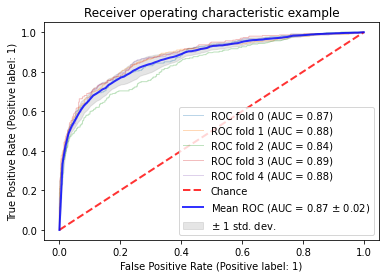

In [16]:
cv = StratifiedKFold(n_splits=5,random_state = 611,shuffle=True)
#classifier = svm.SVC( random_state=5)
#classifier = LogisticRegression(random_state=5)
#classifier = LogisticRegressionCV(random_state=5)
classifier = RandomForestClassifier(max_depth=20,n_estimators = 500, random_state=0)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X6, y6)):
    classifier.fit(X6.iloc[train], y6.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X6.iloc[test],
        y6.iloc[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()

<ipython-input-19-a10fdbacf979>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X6.iloc[train], y6.iloc[train])
<ipython-input-19-a10fdbacf979>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X6.iloc[train], y6.iloc[train])
<ipython-input-19-a10fdbacf979>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X6.iloc[train], y6.iloc[train])
<ipython-input-19-a10fdbacf979>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X6.iloc[train], y6.iloc[train])
<ipython-input-19-a10fdbacf979>:12: Data

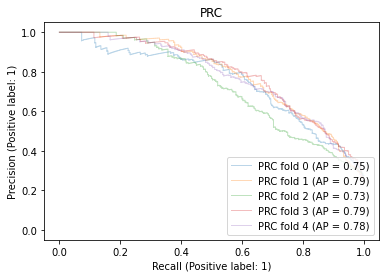

In [19]:
cv = StratifiedKFold(n_splits=5,random_state = 611,shuffle=True)
#classifier = svm.SVC( random_state=5)
#classifier = LogisticRegression(random_state=5)
#classifier = LogisticRegressionCV(random_state=5)
classifier = RandomForestClassifier(max_depth=20,n_estimators = 500, random_state=0,n_jobs=6)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X6, y6)):
    classifier.fit(X6.iloc[train], y6.iloc[train])
    viz = PrecisionRecallDisplay.from_estimator(
        classifier,
        X6.iloc[test],
        y6.iloc[test],
        name="PRC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    #interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    #interp_tpr[0] = 0.0
    #tprs.append(interp_tpr)
    #aucs.append(viz.roc_auc)



ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="PRC",
)
ax.legend(loc="lower right")
plt.show()

In [20]:
np.mean([0.75,0.79,0.73,0.79,0.78])

0.768

In [21]:
np.std([0.75,0.79,0.73,0.79,0.78])

0.02400000000000002

In [81]:
tag_features1 = []
tag_features0 = []

for batch in range(100):
    with open('./labeled_feature_data_local_html/web_html_tag_features_1_'+str(batch)+'.pkl', 'rb') as f:
        tag_features1 += pickle.load(f)

    with open('./labeled_feature_data_local_html/web_html_tag_features_0_'+str(batch)+'.pkl', 'rb') as f:
        tag_features0 += pickle.load(f)

print('tag feature')
print(len(tag_features1))
#print(tag_features1)
print(len(tag_features0))
#print(tag_features0)

tag_features1 = [ft for ind,ft in enumerate(tag_features1) if len(ft) >1]
tag_features0 = [ft for ind,ft in enumerate(tag_features0) if len(ft) >1]

print(len(tag_features1))
print(len(tag_features0))

data = tag_features1 + tag_features0
label = [1 for ft in tag_features1] + [0 for ft in tag_features0]



vectorizer = TfidfVectorizer()
X2 = vectorizer.fit_transform(data)
y2 = np.array(label)

tag feature
5375
13977
5198
13826


In [82]:
#pickle.dump(vectorizer, open('webtag_tfidf', 'wb'))

In [83]:
classifier = RandomForestClassifier(max_depth=20,n_estimators = 500, random_state=0).fit(X2, y2)

In [84]:
term_weights = dict(zip(vectorizer.get_feature_names_out(), classifier.feature_importances_))

In [85]:
dict(sorted(term_weights.items(), key=lambda item: item[1]))

{'awards': 0.0,
 'calls': 0.0,
 'classifications': 0.0,
 'fetch': 0.0,
 'flags': 0.0,
 'game': 0.0,
 'gameplay': 0.0,
 'hotness': 0.0,
 'include': 0.0,
 'kickstarter': 0.0,
 'links': 0.0,
 'marketplace': 0.0,
 'metaanalisis': 0.0,
 'play': 0.0,
 'polypad': 0.0,
 'promotedvideos': 0.0,
 'recs': 0.0,
 'submodule': 0.0,
 'tabs': 0.0,
 'xref': 0.0,
 'single': 1.84289575037266e-10,
 'mstyle': 1.2883229153450336e-09,
 'one': 2.572205547892341e-09,
 'ethos': 3.2913976103184157e-09,
 'lijacques': 5.299248657490958e-09,
 'subscription': 7.166637124281165e-09,
 'trabalho': 8.003214071968703e-09,
 'threads': 8.826819304866898e-09,
 'fans': 9.19358019807513e-09,
 'sociales': 9.64133727989136e-09,
 'leaderboard': 9.688931042552582e-09,
 'if': 9.894574461193811e-09,
 'persistent': 1.047764331915104e-08,
 'hist': 1.1306953043741168e-08,
 'literature': 1.1396320129934132e-08,
 'for': 1.2324716219784615e-08,
 'socio': 1.4541009488286139e-08,
 'mmultiscripts': 1.488436958524613e-08,
 'overview': 1.68107

In [88]:
#scaler = preprocessing.StandardScaler().fit(X2)
lr = LogisticRegression(random_state=0,max_iter=1000).fit(X2, y2)
lr.coef_

array([[-1.18581594e-02,  3.05110041e-03,  2.45603096e-01,
        -7.71145800e-01, -6.10878430e-02, -1.13910890e-02,
        -9.82640851e-03, -3.43796092e-02, -3.83195871e-02,
        -1.75748227e+00,  4.54336572e-03,  1.51993836e-02,
         2.76636586e-01,  1.60206119e-01, -4.74556953e-03,
        -1.21366996e+00,  3.58840570e-01,  3.53848521e-02,
         1.48124912e-02, -7.02149650e-03, -1.29614388e-02,
        -1.98057843e-02,  1.62297290e-03, -1.23951543e-01,
        -1.46226866e-03, -4.74556953e-03, -1.13349053e-02,
        -1.45315104e-01,  2.07718858e-02, -5.87436611e-01,
        -4.40268982e-01, -7.90614622e-02, -4.74556953e-03,
        -8.51126414e-03, -4.43417313e-01, -3.28458399e-02,
        -1.43785331e+00,  1.67746061e+00, -3.28458399e-02,
         2.82821193e-05,  2.82821193e-05, -1.83128714e-02,
         1.08102516e-01, -3.28458399e-02, -2.55593691e+00,
        -8.52652969e-03, -1.33253119e-01,  8.59441154e-01,
         3.13539840e-01, -6.80900731e-03, -1.41676688e-0

In [92]:
term_sign = dict(zip(vectorizer.get_feature_names_out(), lr.coef_[0]))

In [113]:
term_sign['li']

1.865142667688465

In [58]:
classifier = RandomForestClassifier(max_depth=20,n_estimators = 500, random_state=0).fit(X2, y2)
pickle.dump(classifier, open('webtag_classifer', 'wb'))

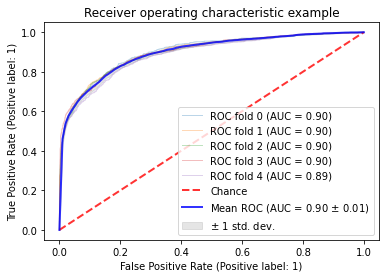

In [26]:
cv = StratifiedKFold(n_splits=5,random_state = 231,shuffle=True)
#classifier = svm.SVC( random_state=5)
#classifier = LogisticRegression(random_state=5)
#classifier = LogisticRegressionCV(random_state=5)
classifier = RandomForestClassifier(max_depth=20,n_estimators = 500, random_state=0,n_jobs=6)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X2, y2)):
    classifier.fit(X2[train], y2[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X2[test],
        y2[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()

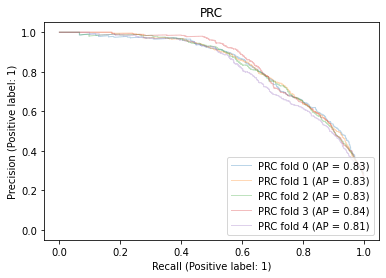

In [27]:
cv = StratifiedKFold(n_splits=5,random_state = 231,shuffle=True)
#classifier = svm.SVC( random_state=5)
#classifier = LogisticRegression(random_state=5)
#classifier = LogisticRegressionCV(random_state=5)
classifier = RandomForestClassifier(max_depth=20,n_estimators = 500, random_state=0,n_jobs=6)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X2, y2)):
    classifier.fit(X2[train], y2[train])
    viz = PrecisionRecallDisplay.from_estimator(
        classifier,
        X2[test],
        y2[test],
        name="PRC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    #interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    #interp_tpr[0] = 0.0
    #tprs.append(interp_tpr)
    #aucs.append(viz.roc_auc)



ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="PRC",
)
ax.legend(loc="lower right")
plt.show()

In [28]:
np.mean([0.83,0.83,0.83,0.84,0.81])

0.828

In [29]:
np.std([0.83,0.83,0.83,0.84,0.81])

0.00979795897113268

In [114]:
font_features1 = []
font_features0 = []

for batch in range(100):
    with open('./labeled_feature_data_local_html/web_font_features_1_'+str(batch)+'.pkl', 'rb') as f:
        font_features1 += pickle.load(f)

    with open('./labeled_feature_data_local_html/web_font_features_0_'+str(batch)+'.pkl', 'rb') as f:
        font_features0 += pickle.load(f)

print('font feature')
print(len(font_features1))
print(len(font_features0))
font_feature1 = [ft for ind,ft in enumerate(font_features1) if len(ft) > 0]
font_feature0 = [ft for ind,ft in enumerate(font_features0) if len(ft) > 0]
font_feature = font_feature1 + font_feature0
label = [1 for ft in font_feature1] + [0 for ft in font_feature0]

print(len(font_feature1))
print(len(font_feature0))

vectorizer = TfidfVectorizer()
X3 = vectorizer.fit_transform([' '.join(ff) for ff in font_feature])
y3 = np.array(label)

font feature
5375
13977
2277
6749


In [115]:
#pickle.dump(vectorizer, open('webfont_tfidf', 'wb'))

In [116]:
classifier = RandomForestClassifier(max_depth=20,n_estimators = 500, random_state=0).fit(X3, y3)
term_weights = dict(zip(vectorizer.get_feature_names_out(), classifier.feature_importances_))
dict(sorted(term_weights.items(), key=lambda item: item[1]))

{'55roma': 0.0,
 'abril': 0.0,
 'bright': 0.0,
 'cairo': 0.0,
 'cherry': 0.0,
 'coda': 0.0,
 'din': 0.0,
 'ditty': 0.0,
 'exo2': 0.0,
 'extrabld': 0.0,
 'fatface': 0.0,
 'fontawesomeslick': 0.0,
 'frutiger': 0.0,
 'gfs': 0.0,
 'goudytwentyregular': 0.0,
 'kudryashov': 0.0,
 'lusitana': 0.0,
 'mdl2': 0.0,
 'metamorphous': 0.0,
 'momizat': 0.0,
 'museoslab500regular': 0.0,
 'mwf': 0.0,
 'orig_wix_madefor_text_regular': 0.0,
 'panton': 0.0,
 'smythe': 0.0,
 'swissra': 0.0,
 'tajawal': 0.0,
 'the': 0.0,
 'thesansuhh': 0.0,
 'thesansuhhbold': 0.0,
 'thesansuhhboldcaps': 0.0,
 'thesansuhhbolditalic': 0.0,
 'thesansuhhitalic': 0.0,
 'thesansuhhregularcaps': 0.0,
 'thesansuhhsemilightcaps': 0.0,
 'universroman': 0.0,
 'wf_6273ae5a6a0a43a88c1a7a047': 0.0,
 'wfont_e28ccf_515bc3734d9f447bafa4a28bc024f1b5': 0.0,
 'ヒラギノ角ゴpro': 0.0,
 'iconvault': 2.721979615852728e-10,
 'wfont_e28ccf_6273ae5a6a0a43a88c1a7a04793c7104': 4.4001282566761616e-10,
 'fjord': 1.5216068088315107e-09,
 'yekanywyw': 1.52416140

In [117]:
lr = LogisticRegression(random_state=0,max_iter=1000).fit(X3, y3)
lr.coef_

array([[-1.58867154e-01, -1.80538155e-01,  9.56628725e-01,
        -5.32093224e-02, -1.98583943e-02, -4.23107404e-03,
        -3.03908633e-02,  8.43822243e-02, -9.71594369e-03,
        -1.19252959e-01, -8.44124581e-02, -8.44124581e-02,
        -1.98583943e-02, -5.93480893e-02,  9.70670180e-02,
        -5.06105089e-02, -3.63102662e-02, -1.01221018e-01,
        -3.03908633e-02, -7.14480509e-02, -1.98583943e-02,
         3.23556727e-02, -3.54239127e-01, -1.39663204e-01,
         3.66226260e-01, -5.06105089e-02, -7.14480509e-02,
        -7.39848320e-03, -1.98583943e-02,  4.09936819e-02,
         7.19386922e-01,  6.15479987e-01, -1.64837591e-01,
        -1.69536286e-01, -4.39978042e-02, -4.88329314e-02,
        -5.10540435e-02,  5.01447825e-01, -1.33459517e-02,
         6.08798680e-01, -2.17196607e-01,  8.05314751e-01,
         2.81416888e-01, -4.09575208e-02, -3.68488497e-03,
        -9.80486182e-01,  1.19878855e-01,  4.29175402e-02,
         2.48216039e-01,  5.44215646e-02, -9.26946959e-0

In [118]:
term_sign = dict(zip(vectorizer.get_feature_names_out(), lr.coef_[0]))

In [119]:
term_sign

{'0625em': -0.15886715429614864,
 '063em': -0.1805381554329534,
 '10': 0.9566287246938694,
 '120': -0.053209322382276956,
 '120em': -0.01985839428701858,
 '12px': -0.004231074037689956,
 '13': -0.030390863266238247,
 '27px': 0.08438222425160527,
 '3d': -0.009715943694109545,
 '40': -0.119252958557921,
 '400': -0.08441245813601421,
 '400italic': -0.08441245813601421,
 '40em': -0.01985839428701858,
 '45ligh': -0.05934808929527339,
 '45light': 0.09706701798224321,
 '55': -0.05061050886215991,
 '55roma': -0.03631026622749757,
 '55roman': -0.10122101772431982,
 '5px': -0.030390863266238247,
 '64': -0.07144805092247265,
 '64em': -0.01985839428701858,
 '65bold': 0.0323556726607478,
 '65medi': -0.35423912703601507,
 '67': -0.139663203799019,
 '700': 0.36622626038539546,
 '75bold': -0.05061050886215991,
 '90': -0.07144805092247265,
 '900': -0.007398483200698469,
 '90em': -0.01985839428701858,
 'a11y': 0.04099368190665986,
 'abeezee': 0.7193869224452389,
 'abel': 0.6154799874615371,
 'abril': -0

In [129]:
term_sign['neue']

-0.7214458734672509

In [33]:
len(label)

9026

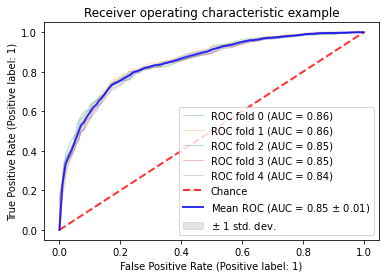

In [34]:
cv = StratifiedKFold(n_splits=5,random_state = 231,shuffle=True)
#classifier = svm.SVC( random_state=5)
#classifier = LogisticRegression(random_state=5)
#classifier = LogisticRegressionCV(random_state=5)
classifier = RandomForestClassifier(max_depth=20,n_estimators = 500, random_state=0)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X3, y3)):
    classifier.fit(X3[train], y3[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X3[test],
        y3[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()

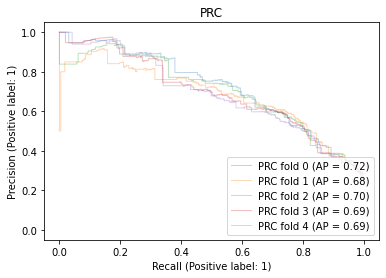

In [36]:
cv = StratifiedKFold(n_splits=5,random_state = 231,shuffle=True)
#classifier = svm.SVC( random_state=5)
#classifier = LogisticRegression(random_state=5)
#classifier = LogisticRegressionCV(random_state=5)
classifier = RandomForestClassifier(max_depth=20,n_estimators = 500, random_state=0,n_jobs=6)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X3, y3)):
    classifier.fit(X3[train], y3[train])
    viz = PrecisionRecallDisplay.from_estimator(
        classifier,
        X3[test],
        y3[test],
        name="PRC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    #interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    #interp_tpr[0] = 0.0
    #tprs.append(interp_tpr)
    #aucs.append(viz.roc_auc)



ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="PRC",
)
ax.legend(loc="lower right")
plt.show()

In [37]:
np.mean([0.72,0.68,0.70,0.69,0.69])

0.696

In [38]:
np.std([0.72,0.68,0.70,0.69,0.69])

0.013564659966250522

In [130]:
color_features1 = []
color_features0 = []

for batch in range(100):
    with open('./labeled_feature_data_local_html/web_color_features_1_'+str(batch)+'.pkl', 'rb') as f:
        color_features1 += pickle.load(f)

    with open('./labeled_feature_data_local_html/web_color_features_0_'+str(batch)+'.pkl', 'rb') as f:
        color_features0 += pickle.load(f)

print('color feature')
#print(color_features1)
#print(color_features0)
color_features1 = [ft for ind,ft in enumerate(color_features1) if len(ft) ==5]
color_features0 = [ft for ind,ft in enumerate(color_features0) if len(ft) ==5]
website_colors = color_features1 + color_features0
label = [1 for ft in color_features1] + [0 for ft in color_features0]


vectorizer = TfidfVectorizer()
X4 = vectorizer.fit_transform([' '.join(set(ff)) for ff in website_colors])
y4 = np.array(label)

color feature


In [131]:
#pickle.dump(vectorizer, open('webcolor_tfidf', 'wb'))

In [132]:
classifier = RandomForestClassifier(max_depth=20,n_estimators = 500, random_state=0).fit(X4,y4)
term_weights = dict(zip(vectorizer.get_feature_names_out(), classifier.feature_importances_))
dict(sorted(term_weights.items(), key=lambda item: item[1]))

{'aquamarine': 0.0,
 'chartreuse': 0.0,
 'mediumspringgreen': 0.0,
 'orchid': 0.0,
 'lightgreen': 1.3172529147397416e-06,
 'aqua': 1.7404467727335055e-06,
 'lightsalmon': 3.2455080348143254e-06,
 'papayawhip': 4.2407085322680986e-06,
 'lightgoldenrodyellow': 5.73121260925226e-06,
 'deeppink': 6.6808286495095146e-06,
 'azure': 7.517018315701793e-06,
 'mediumorchid': 8.821489533236399e-06,
 'palegreen': 9.053269677140451e-06,
 'cornsilk': 9.345348284098069e-06,
 'ivory': 1.5646015758580502e-05,
 'darkviolet': 1.5994076760467963e-05,
 'peachpuff': 1.7874985387177276e-05,
 'moccasin': 1.8991880096737433e-05,
 'blueviolet': 2.2989244096618287e-05,
 'pink': 2.5851255513901436e-05,
 'turquoise': 2.6527111088967112e-05,
 'lime': 2.8906601879605065e-05,
 'greenyellow': 3.995872490122702e-05,
 'lightpink': 4.039351124464225e-05,
 'blanchedalmond': 4.157077304007459e-05,
 'lavenderblush': 4.972305696421991e-05,
 'fuchsia': 5.3417267123569704e-05,
 'lightcoral': 5.553572979625132e-05,
 'plum': 5.7

In [133]:
lr = LogisticRegression(random_state=0,max_iter=1000).fit(X4, y4)
lr.coef_

array([[ 0.65880268,  0.22975735, -0.30762502, -0.67501861,  0.11474013,
         0.88477729, -1.41573984,  0.79040254, -0.18989007,  0.38744004,
        -0.35921684, -0.93154892, -0.50677502, -0.18985349, -0.23070752,
         0.39053772,  0.20552397, -0.13231963, -0.53070687, -0.16657954,
        -0.43031799, -0.58205854,  0.0052952 , -0.48719703,  0.39200342,
         0.30161048, -0.5086535 , -0.21528298,  0.27123349,  0.44980704,
        -0.68934402, -0.66691926,  0.02008793, -0.04752488, -0.72682498,
        -0.62050221, -0.90850597, -0.52745512,  1.5197115 , -0.33096831,
         1.14875265,  1.47103295,  0.12131913, -0.35782081,  0.53455861,
         0.21624626,  0.02410698, -0.28194585, -0.87364541, -0.56268391,
         0.494405  , -0.97318645,  0.40554321,  0.82140416,  0.1749185 ,
        -0.30327172, -1.15389194, -0.08464713,  0.14505525, -0.21518376,
         0.75418072,  0.24656418,  0.01228693, -0.12409428, -0.06922967,
        -1.0184443 , -0.37370324, -1.1542142 , -0.9

In [134]:
term_sign = dict(zip(vectorizer.get_feature_names_out(), lr.coef_[0]))

In [135]:
term_sign

{'aliceblue': 0.6588026849224059,
 'antiquewhite': 0.22975734576682624,
 'aqua': -0.30762501998115577,
 'aquamarine': -0.6750186086677843,
 'azure': 0.11474012636064962,
 'beige': 0.8847772876856064,
 'bisque': -1.4157398406950106,
 'black': 0.7904025447474089,
 'blanchedalmond': -0.18989006657160817,
 'blue': 0.38744004289941525,
 'blueviolet': -0.35921683883595185,
 'brown': -0.9315489164448935,
 'burlywood': -0.5067750241158837,
 'cadetblue': -0.18985348606781105,
 'chartreuse': -0.23070752465368333,
 'chocolate': 0.3905377163788009,
 'coral': 0.20552396679284266,
 'cornflowerblue': -0.1323196319786381,
 'cornsilk': -0.5307068711417501,
 'crimson': -0.16657954425594004,
 'darkblue': -0.43031799170594026,
 'darkcyan': -0.5820585356252,
 'darkgoldenrod': 0.005295201686960056,
 'darkgray': -0.4871970348143154,
 'darkgreen': 0.39200341779471576,
 'darkkhaki': 0.3016104766586001,
 'darkmagenta': -0.5086534958465392,
 'darkolivegreen': -0.21528297991231535,
 'darkorange': 0.27123348719589

In [145]:
term_sign['darkgray']

-0.4871970348143154

In [46]:
len(website_colors)

18530

In [47]:
len(label)

18530

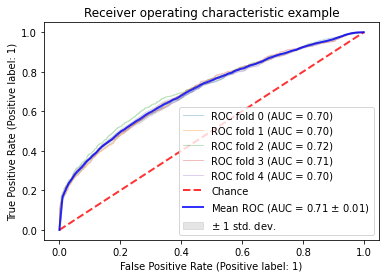

In [48]:
cv = StratifiedKFold(n_splits=5,random_state = 231,shuffle=True)
#classifier = svm.SVC( random_state=5)
#classifier = LogisticRegression(random_state=5)
#classifier = LogisticRegressionCV(random_state=5)
classifier = RandomForestClassifier(max_depth=20, n_estimators = 500, random_state=0)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X4, y4)):
    classifier.fit(X4[train], y4[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X4[test],
        y4[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()

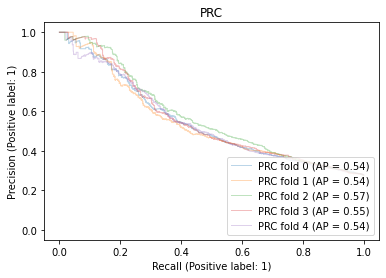

In [49]:
cv = StratifiedKFold(n_splits=5,random_state = 231,shuffle=True)
#classifier = svm.SVC( random_state=5)
#classifier = LogisticRegression(random_state=5)
#classifier = LogisticRegressionCV(random_state=5)
classifier = RandomForestClassifier(max_depth=20,n_estimators = 500, random_state=0,n_jobs=6)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X4, y4)):
    classifier.fit(X4[train], y4[train])
    viz = PrecisionRecallDisplay.from_estimator(
        classifier,
        X4[test],
        y4[test],
        name="PRC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    #interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    #interp_tpr[0] = 0.0
    #tprs.append(interp_tpr)
    #aucs.append(viz.roc_auc)



ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="PRC",
)
ax.legend(loc="lower right")
plt.show()

In [50]:
np.mean([0.54,0.54,0.57,0.55,0.54])

0.548

In [51]:
np.std([0.54,0.54,0.57,0.55,0.54])

0.01166190378969057

In [37]:
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.metrics import roc_auc_score

<ipython-input-54-8556b4541887>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf1 = classifier1.fit(X1.iloc[train], y1.iloc[train])
/home/hzhuang/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-54-8556b4541887>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf1 = classifier1.fit(X1.iloc[train], y1.iloc[train])
/home/hzhuang/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

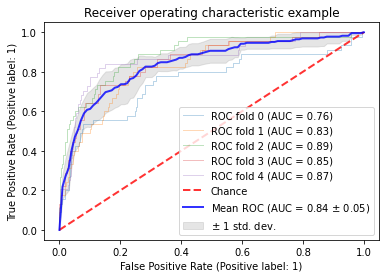

In [54]:
cv = StratifiedKFold(n_splits=5)
classifier1 = RandomForestClassifier(max_depth=5, random_state=0)
classifier2 = RandomForestClassifier(max_depth=5, random_state=0)
classifier3 = RandomForestClassifier(max_depth=5, random_state=0)
classifier4 = RandomForestClassifier(max_depth=5, random_state=0)
classifier = LogisticRegression(random_state=0)
#classifier = RandomForestClassifier(max_depth = 10,n_estimators =500, random_state=0)


tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)


fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X1, y1)):
   
    XX = []
    clf1 = classifier1.fit(X1.iloc[train], y1.iloc[train])
    F1 = clf1.predict_proba(X1.iloc[train])[:, 1]
    #print(roc_auc_score(y1.iloc[train],F1))
    clf2 = classifier2.fit(X2[train], y2[train])
    F2 = clf2.predict_proba(X2[train])[:, 1]
    #print(roc_auc_score(y1.iloc[train],F2))
    clf3 = classifier3.fit(X3[train], y3[train])
    F3 = clf3.predict_proba(X3[train])[:, 1]
    #print(roc_auc_score(y1.iloc[train],F3))
    clf4 = classifier4.fit(X4[train], y4[train])
    F4 = clf4.predict_proba(X4[train])[:, 1]
    #print(roc_auc_score(y1.iloc[train],F4))
    
    XX0 = []
    X01 = clf1.predict_proba(X1.iloc[test])[:, 1]
    #print(roc_auc_score(y1.iloc[test],X01))
    X02 = clf2.predict_proba(X2[test])[:, 1]
    #print(roc_auc_score(y1.iloc[test],X02))
    X03 = clf3.predict_proba(X3[test])[:, 1]
    #print(roc_auc_score(y1.iloc[test],X03))
    X04 = clf4.predict_proba(X4[test])[:, 1]
    #print(roc_auc_score(y1.iloc[test],X04))
    
    for ind, xx in enumerate(F1):
        #XX.append([F1[ind],F2[ind],F3[ind]])
        XX.append([F1[ind],F2[ind],F3[ind],F4[ind]])
        #XX.append([F1[ind]])
    
    for ind, xx in enumerate(X01):
        #XX0.append([X01[ind],X02[ind],X03[ind]])
        XX0.append([X01[ind],X02[ind],X03[ind],X04[ind]])
        #XX0.append([X01[ind]])
        
    
    
    classifier.fit(XX, np.array(y1)[train])
    #print(classifier.coef_)
    #print(len(XX0))
    #print(np.array(XX0)[test])
    
    viz = RocCurveDisplay.from_estimator(
        classifier,
        np.array(XX0),
        y1.iloc[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()

# Error analysis Connect different features into one feature to predict NO DATA IMPUTATION

In [1]:
import pickle
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

In [2]:
web_features1 = []
web_features0 = []

for batch in range(0,100):
    with open('./labeled_feature_data_local_html_v1/web_content_features_1_'+str(batch)+'.pkl', 'rb') as f:
        web_features1 += pickle.load(f)

    with open('./labeled_feature_data_local_html_v1/web_content_features_0_'+str(batch)+'.pkl', 'rb') as f:
        web_features0 += pickle.load(f)
    
web_features1 = [[ind]+ft for ind,ft in enumerate(web_features1)]
web_features0 = [[ind]+ft for ind,ft in enumerate(web_features0)]

In [3]:
len(web_features1)+len(web_features0)

19352

In [77]:
len(web_features1)

5375

In [4]:
web_features1[0]

[0, 'Empty', 19473, 0, 'Empty', -1, -1, -1, -1]

In [5]:
abs_features1 = []
abs_features0 = []

for batch in range(100):
    with open('./labeled_feature_data_local_html_v1/web_content_features_1_'+str(batch)+'_abs.pkl', 'rb') as f:
        tmp = pickle.load(f)
        for t in tmp:
            #print(t)
            if len(t) == 2 and len(t[1]) == 0:
                dt = [0]
            elif len(t) !=0:
                tt = []
                for c in t:
                    if len(c) == 10:
                        tt.append(c)
                   
                #print(tt)
                if len(tt) != 0:
                    dt = np.mean(np.array(tt), axis=0)
                else:
                    dt = [0]
                #print(len(dt))
            abs_features1.append(dt)
            
        #dt = [[tt for tt in t if len(tt) == 10] for t in tmp if len(t) >0 and len([tt for tt in t if len(tt)==10])]
        #print(dat)
        #abs_features1 += [np.mean(np.array(t), axis=0) for t in dt]

    with open('./labeled_feature_data_local_html_v1/web_content_features_0_'+str(batch)+'_abs.pkl', 'rb') as f:
    
        tmp = pickle.load(f)
     
        for t in tmp:
            #print(t)
            if len(t) == 2 and len(t[1]) == 0:
                dt = [0]
            elif len(t) !=0:
                tt = []
                for c in t:
                    if len(c) == 10:
                        tt.append(c)
              
                #print(tt)
                if len(tt) != 0:
                    dt = np.mean(np.array(tt), axis=0)
                else:
                    dt = [0]
                #print(len(dt))
                
            abs_features0.append(dt)
        
    
        
        #dt = [[tt for tt in t if len(tt) == 10] for t in tmp if len(t) >0 and len([tt for tt in t if len(tt)==10])]
        
        #abs_features0 += [np.mean(np.array(t), axis=0) for t in dt]


In [86]:
abs_features1 = []

leng = 0
for batch in range(100):
    with open('./labeled_feature_data_local_html_v1/web_content_features_1_'+str(batch)+'_abs.pkl', 'rb') as f:
        tmp = pickle.load(f)
        for t in tmp:
            leng += 1
            print(leng)
            tt = []
            if leng == 4566:
                print(t)
            if len(t) == 2 and len(t[1]) == 0:
                dt = [0]
            elif len(t) !=0:
                print('here')
                for c in t:
                    if len(c) == 10:
                        tt.append(c)
                   
       
            if len(tt) != 0:
                dt = np.mean(np.array(tt), axis=0)
            else:
                dt = [0]
          
            abs_features1.append(dt)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
here
15
here
16
here
17
here
18
here
19
here
20
here
21
here
22
here
23
here
24
here
25
26
27
28
29
30
31
32
33
here
34
35
36
37
38
here
39
here
40
here
41
here
42
here
43
here
44
45
46
here
47
48
49
50
51
52
53
here
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
here
74
here
75
here
76
here
77
here
78
here
79
here
80
here
81
82
83
84
85
here
86
here
87
here
88
89
90
91
92
93
94
95
here
96
here
97
here
98
here
99
here
100
here
101
here
102
here
103
here
104
here
105
here
106
107
108
109
110
111
112
113
114
115
116
here
117
here
118
here
119
120
121
122
123
124
here
125
126
127
128
129
130
131
132
133
134
135
here
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
here
165
here
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
here
191
192
193
194
195
196
197
198
199
200
201
202
here
203
204
205
206
207
208
209
210
211
212
213
2

2587
here
2588
here
2589
here
2590
here
2591
here
2592
here
2593
here
2594
here
2595
2596
here
2597
here
2598
2599
here
2600
here
2601
2602
here
2603
here
2604
here
2605
here
2606
here
2607
2608
2609
here
2610
here
2611
here
2612
here
2613
here
2614
here
2615
here
2616
here
2617
here
2618
2619
here
2620
here
2621
here
2622
here
2623
here
2624
2625
here
2626
here
2627
here
2628
here
2629
here
2630
here
2631
here
2632
here
2633
here
2634
here
2635
here
2636
here
2637
here
2638
here
2639
2640
here
2641
here
2642
here
2643
here
2644
here
2645
here
2646
here
2647
here
2648
here
2649
here
2650
here
2651
here
2652
2653
here
2654
here
2655
here
2656
here
2657
here
2658
2659
2660
2661
2662
here
2663
2664
here
2665
here
2666
2667
2668
here
2669
2670
2671
here
2672
here
2673
here
2674
2675
2676
here
2677
2678
2679
2680
here
2681
here
2682
2683
2684
2685
here
2686
2687
2688
here
2689
here
2690
here
2691
2692
2693
here
2694
here
2695
here
2696
here
2697
2698
2699
2700
2701
2702
here
2703
here
2704


In [85]:
abs_features1[4566]

[0]

In [6]:
tag_features1 = []
tag_features0 = []

for batch in range(100):
    with open('./labeled_feature_data_local_html_v1/web_html_tag_features_1_'+str(batch)+'.pkl', 'rb') as f:
        tag_features1 += pickle.load(f)

    with open('./labeled_feature_data_local_html_v1/web_html_tag_features_0_'+str(batch)+'.pkl', 'rb') as f:
        tag_features0 += pickle.load(f)

In [7]:
font_features1 = []
font_features0 = []

for batch in range(100):
    with open('./labeled_feature_data_local_html_v1/web_font_features_1_'+str(batch)+'.pkl', 'rb') as f:
        font_features1 += pickle.load(f)

    with open('./labeled_feature_data_local_html_v1/web_font_features_0_'+str(batch)+'.pkl', 'rb') as f:
        font_features0 += pickle.load(f)


In [8]:
color_features1 = []
color_features0 = []

for batch in range(100):
    with open('./labeled_feature_data_local_html_v1/web_color_features_1_'+str(batch)+'.pkl', 'rb') as f:
        color_features1 += pickle.load(f)

    with open('./labeled_feature_data_local_html_v1/web_color_features_0_'+str(batch)+'.pkl', 'rb') as f:
        color_features0 += pickle.load(f)

In [9]:
len(web_features1),len(web_features0),

(5375, 13977)

In [10]:
len(abs_features1),len(abs_features0),

(5375, 13977)

In [11]:
len(tag_features1),len(tag_features0),

(5375, 13977)

In [12]:
len(font_features1),len(font_features0),

(5375, 13977)

In [13]:
len(color_features1),len(color_features0),

(5375, 13977)

In [14]:
#drop two duplicated columns: save value but different column name
bibilometrics = pd.read_csv('labeled_journals_biblio_features_all.csv').drop(columns=['journal_paper_cited_num','journal_journal_reference_num'])

In [15]:
bibilometrics.head(3)

,JournalId,NormalizedName,Issn,Reason,num_journal_publication,num_journal_author,num_journal_affiliation,journal_year_first_publish,journal_avg_hindex,journal_avg_first_author_hindex,...,journal_num_author_referenced,journal_num_author_cited,journal_num_affiliation_referenced,journal_num_affiliation_cited,journal_num_journal_self_reference,journal_num_author_self_reference,journal_num_affiliation_self_reference,journal_num_journal_self_cited,journal_num_author_self_cited,journal_num_affiliation_self_cited
0,2764959905,austrian journal of humanities and social scie...,Unknown,A,1364,48,48,2012,1.000000,1.000000,...,122,83,28,12,0,0,0,0,1,0
1,2764494681,austrian journal of technical and natural scie...,Unknown,A,826,36,36,2014,1.880952,2.058824,...,193,214,52,21,0,1,0,0,3,0
2,2764967488,european journal of arts,Unknown,A,372,5,5,2015,1.000000,1.000000,...,13,7,2,1,0,0,0,0,0,0


In [16]:
white_bib = bibilometrics[bibilometrics['Reason'] == 'Still in DOAJ index'].drop(columns=['JournalId','Issn','NormalizedName','Reason'])
white_bib['label'] = 0
unwhite_bib = bibilometrics[bibilometrics['Reason'] != 'Still in DOAJ index'].drop(columns=['JournalId','Issn','NormalizedName','Reason'])
unwhite_bib['label'] = 1

In [17]:
white_bib.shape

(4281, 23)

In [18]:
unwhite_bib.shape

(1502, 23)

In [19]:
labeled_journals = pd.read_csv('merge_journal_list_interesting_url_all_unique_normalizedname.csv')

In [20]:
labeled_journals.head(3)

,Journal Title,ISSN,Reason,Journal Title Normalized,URL,Data Source,added,Remove_Date,Add_Date,reason_category
0,Journal of Algebraic Systems,NaN,Still in DOAJ index,journal of algebraic systems,http://jas.shahroodut.ac.ir/,DOAJ,1.0,1300-01-01 00:00:00,2019-01-26 00:00:00,interesting reason
1,Revista Pró-UniverSUS,NaN,Still in DOAJ index,revista pró-universus,http://editora.universidadedevassouras.edu.br/...,DOAJ,1.0,1300-01-01 00:00:00,2019-05-08 00:00:00,interesting reason
2,Austrian Journal of Humanities and Social Scie...,Unknown,A,austrian journal of humanities and social scie...,https://ew-a.org/journals/61/,Gray OA,NaN,NaN,NaN,interesting reason


In [21]:
labeled_journals.shape

(19352, 10)

In [22]:
bib_features0 = []
bib_features_ind0 = []
counter = 0
for ind,row in labeled_journals[labeled_journals['Reason'] == 'Still in DOAJ index'].iterrows():
    if row['Journal Title Normalized'] in (bibilometrics['NormalizedName'].tolist()):
        tmp = bibilometrics.index[bibilometrics['NormalizedName']==row['Journal Title Normalized']]
        #print(tmp)
        val = bibilometrics.iloc[tmp].drop(columns=['JournalId','Issn','NormalizedName','Reason']).values.tolist()[0]
        #print(val)
        #print(len(val))
        bib_features0.append(val)
        bib_features_ind0.append(counter)
    else:
        bib_features0.append([0]*22)
    counter += 1
        


In [23]:
counter

13977

In [24]:
len(bib_features_ind0)

4255

In [25]:
bib_features1 = []
bib_features_ind1 = []
counter = 0
for ind,row in labeled_journals[labeled_journals['Reason'] != 'Still in DOAJ index'].iterrows():
    if row['Journal Title Normalized'] in (bibilometrics['NormalizedName'].tolist()):
        tmp = bibilometrics.index[bibilometrics['NormalizedName']==row['Journal Title Normalized']]
        #print(tmp)
        val = bibilometrics.iloc[tmp].drop(columns=['JournalId','Issn','NormalizedName','Reason']).values.tolist()[0]
        #print(val)
        #print(len(val))
        bib_features1.append(val)
        bib_features_ind1.append(counter)
    else:
        bib_features1.append([0]*22)
    counter += 1

In [26]:
counter

5375

In [27]:
len(bib_features0),len(bib_features1)

(13977, 5375)

In [28]:
web_features_ind0 = [ind for ind,ft in enumerate(web_features0) if len(ft) >9]
web_features_ind1 = [ind for ind,ft in enumerate(web_features1) if len(ft) >9]

In [29]:
abs_features_ind0 = [ind for ind,ft in enumerate(abs_features0) if len(ft) >9]
abs_features_ind1 = [ind for ind,ft in enumerate(abs_features1) if len(ft) >9]

In [30]:
tag_features_ind0 = [ind for ind,ft in enumerate(tag_features0) if len(ft) >1]
tag_features_ind1 = [ind for ind,ft in enumerate(tag_features1) if len(ft) >1]

In [31]:
font_features_ind0 = [ind for ind,ft in enumerate(font_features0) if len(ft) > 0]
font_features_ind1 = [ind for ind,ft in enumerate(font_features1) if len(ft) > 0]

In [32]:
color_features_ind0 = [ind for ind,ft in enumerate(color_features0) if len(ft) ==5]
color_features_ind1 = [ind for ind,ft in enumerate(color_features1) if len(ft) ==5]

In [33]:
len(bib_features_ind1),len(bib_features_ind0),

(1493, 4255)

In [34]:
len(web_features_ind1),len(web_features_ind0),

(4801, 9484)

In [35]:
len(abs_features_ind1),len(abs_features_ind0),

(3498, 6736)

In [36]:
len(tag_features_ind1),len(tag_features_ind0),

(5198, 13826)

In [37]:
len(font_features_ind1),len(font_features_ind0),

(2277, 6749)

In [38]:
len(color_features_ind1),len(color_features_ind0),

(5083, 13447)

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [40]:
vectorizer = TfidfVectorizer()

In [41]:
web_features_use = []
bib_features_use = []
abs_features_use = []
tag_features_use = []
font_features_use = []
color_features_use = []
label = []

In [42]:
for ind,v in enumerate(zip(web_features0,bib_features0,abs_features0,tag_features0,font_features0,color_features0)):
    w = v[0]
    b = v[1]
    a = v[2]
    t = v[3]
    f = v[4]
    c = v[5]
    if ind in web_features_ind0 and ind in bib_features_ind0 and ind in abs_features_ind0 and ind in tag_features_ind0 and ind in font_features_ind0 and ind in color_features_ind0:
        web_features_use.append(w)
        bib_features_use.append(b)
        abs_features_use.append(a)
        tag_features_use.append(t)
        font_features_use.append(f)
        color_features_use.append(c)
        label.append(0)

In [43]:
len(web_features_use)

1345

In [44]:
for ind,v in enumerate(zip(web_features1,bib_features1,abs_features1,tag_features1,font_features1,color_features1)):
    w = v[0]
    b = v[1]
    a = v[2]
    t = v[3]
    f = v[4]
    c = v[5]
    if ind in web_features_ind1 and ind in bib_features_ind1 and ind in abs_features_ind1 and ind in tag_features_ind1 and ind in font_features_ind1 and ind in color_features_ind1:
        web_features_use.append(w)
        bib_features_use.append(b)
        abs_features_use.append(a)
        tag_features_use.append(t)
        font_features_use.append(f)
        color_features_use.append(c)
        label.append(1)

In [45]:
len(web_features_use)

1739

In [46]:
content_x = web_features_use

In [47]:
bib_x = bib_features_use

In [48]:
abstract_x = abs_features_use

In [49]:
tag_x = vectorizer.fit_transform(tag_features_use).todense()

In [50]:
len(tag_x[0].tolist()[0])

308

In [51]:
font_x = vectorizer.fit_transform([' '.join(set(ff)) for ff in font_features_use]).todense()

In [52]:
color_x = vectorizer.fit_transform([' '.join(set(ff)) for ff in color_features_use]).todense()

In [53]:
X = []

In [54]:
abstract_x[0].tolist()

[20.05,
 17.46,
 17.69,
 16.175000000000004,
 11.379000000000001,
 20.250000000000004,
 57.3,
 18.5025,
 18.433,
 15.619999999999996]

In [55]:
len(content_x[0])

18

In [56]:
content_x[0]

[20,
 23.43,
 19.7,
 20.3,
 13.94,
 11.37,
 23.7,
 32,
 14.8,
 22.44,
 9.31,
 7249.75,
 21,
 -1,
 -1,
 1,
 -1,
 0]

In [57]:
X = []

In [58]:
for ind,w in enumerate(web_features_use):
    X.append(w+bib_x[ind]+abstract_x[ind].tolist()+tag_x[ind].tolist()[0]+font_x[ind].tolist()[0]+color_x[ind].tolist()[0])

In [59]:
abstract_x

[array([20.05  , 17.46  , 17.69  , 16.175 , 11.379 , 20.25  , 57.3   ,
        18.5025, 18.433 , 15.62  ]),
 array([3.00000000e-02, 1.80142857e+01, 9.62857143e+00, 2.90500000e+01,
        1.33900000e+01, 2.83571429e+01, 3.11428571e+01, 1.32976190e+01,
        2.10528571e+01, 8.26000000e+00]),
 array([26.11444444, 16.13333333, 16.66666667, 15.39777778,  9.81666667,
        18.65555556, 47.77777778, 17.52777778, 15.68111111, 16.72777778]),
 array([-305.03428571,   64.825     ,    8.9       ,   16.32357143,
           8.57178571,   26.05357143,  167.75      ,   18.12895408,
          17.58428571,  323.12142857]),
 array([36.62,  8.4 ,  0.  ,  1.  , 19.48, 16.8 ,  1.  , -0.5 ,  0.4 ,
         0.12]),
 array([ 8.432, 17.56 , 18.04 , 19.078, 10.03 , 19.7  , 46.8  , 14.58 ,
        15.206, 15.834]),
 array([-1852.495,   275.65 ,     8.55 ,    26.09 ,    15.615,    28.7  ,
           21.   ,     9.625,    29.065,     5.315]),
 array([-0.44 , 22.6  ,  0.   , 15.97 , 11.6  , 24.4  , 19.   , 12.1

In [60]:
len(content_x)

1739

In [61]:
len(X)

1739

In [62]:
len(label)

1739

In [63]:
bib_x[0]

[34.0,
 158.0,
 158.0,
 2015.0,
 9.05501567398119,
 6.0,
 7.794117647058823,
 7.119501100751101,
 778.0,
 203.0,
 32.0,
 94.0,
 3021.0,
 867.0,
 491.0,
 254.0,
 3.0,
 15.0,
 12.0,
 3.0,
 6.0,
 7.0]

In [64]:
import numpy as np

In [65]:
X2 = np.array(X)
y2 = np.array(label)

In [66]:
df_all = pd.DataFrame(X2)

In [67]:
df_all['label'] = label

In [68]:
df_all.shape

(1739, 854)

In [69]:
df_all

,0,1,2,3,4,5,6,7,8,9,...,844,845,846,847,848,849,850,851,852,label
0,20.0,23.43,19.7,20.3,13.94,11.37,23.7,32.0,14.800000,22.44,...,0.000000,0.0,0.0,0.0,0.0,0.290788,0.420907,0.0,0.0,0
1,37.0,-3.69,17.7,16.3,21.52,13.15,19.2,24.0,13.166667,19.05,...,0.525125,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0
2,42.0,38.01,12.0,14.2,15.08,10.03,13.7,20.0,11.875000,14.52,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0
3,67.0,-14.82,24.0,19.3,18.52,11.29,25.7,97.0,20.500000,20.35,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0
4,93.0,-27.85,27.0,0.0,22.58,13.99,30.8,38.0,36.250000,28.96,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1734,5318.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.00,...,0.000000,0.0,0.0,0.0,0.0,0.247061,0.357613,0.0,0.0,1
1735,5337.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.00,...,0.523126,0.0,0.0,0.0,0.0,0.266446,0.385672,0.0,0.0,1
1736,5342.0,20.89,20.7,18.5,14.52,10.41,34.3,98.0,24.000000,20.94,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1
1737,5343.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.00,...,0.000000,0.0,0.0,0.0,0.0,0.298149,0.000000,0.0,0.0,1


In [72]:
df_all[df_all[0]==4566].iloc[1:,40:50]

,40,41,42,43,44,45,46,47,48,49
1633,-0.735,22.75,20.0,16.135,11.785,24.85,57.0,13.266667,21.96,15.125


In [82]:
df_random = df_all.sample(frac=1, random_state=1)

In [83]:
df_random.shape

(1739, 854)

In [84]:
1739*0.7

1217.3

In [85]:
df_train = df_random.iloc[:1217,:]

In [86]:
df_test = df_random.iloc[1217:,:]

In [87]:
X1 = df_train.loc[:, df_train.columns != 'label']

In [88]:
X_test0 = df_test.loc[:, df_test.columns != 'label']
X_test = X_test0.loc[:, X_test0.columns != 0]
y_test = df_test.loc[:, df_test.columns == 'label']

In [89]:
X2 = X1.loc[:, X1.columns != 0]
y2 = df_train.loc[:, df_train.columns == 'label']

In [90]:
X3 = np.array(X2)
y3 = np.array(y2)

In [91]:
np.mean(y3)

0.2161051766639277

In [92]:
np.mean(y_test)

label    0.250958
dtype: float64

In [93]:
classifier = RandomForestClassifier(max_depth=20,n_estimators = 500, random_state=0,n_jobs=6)

In [94]:
classifier.fit(X3,y3)

<ipython-input-94-f2ade62a9fe1>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X3,y3)


RandomForestClassifier(max_depth=20, n_estimators=500, n_jobs=6, random_state=0)

In [95]:
res = classifier.predict(X_test)

In [96]:
res_prob = classifier.predict_proba(X_test)

In [97]:
res_prob

array([[0.97736989, 0.02263011],
       [0.9697589 , 0.0302411 ],
       [0.81323087, 0.18676913],
       ...,
       [0.63386588, 0.36613412],
       [0.91093637, 0.08906363],
       [0.84932211, 0.15067789]])

In [98]:
from sklearn.metrics import roc_auc_score

In [99]:
res_prob[:,1]

array([2.26301132e-02, 3.02411001e-02, 1.86769130e-01, 3.10875124e-01,
       1.87349189e-03, 4.27833004e-02, 2.86452542e-02, 8.92421743e-02,
       2.73677654e-01, 1.56971898e-01, 3.99872467e-01, 7.57381608e-02,
       4.66459487e-01, 8.98091859e-03, 1.27421438e-02, 1.17552122e-01,
       3.07212030e-01, 2.46986759e-02, 9.10102968e-02, 1.74460265e-01,
       2.16933227e-01, 5.69925490e-01, 1.88203976e-02, 5.32241309e-02,
       5.99708285e-02, 1.81007699e-01, 7.32230841e-01, 1.47381443e-02,
       1.33749381e-01, 3.01501131e-01, 7.71748702e-02, 4.08856422e-02,
       4.32751749e-01, 6.33285455e-02, 3.93374862e-01, 8.54478261e-01,
       2.21166846e-01, 4.36560414e-02, 1.17179522e-01, 3.01843434e-01,
       1.31716453e-01, 2.18609444e-01, 1.48349321e-02, 1.24775037e-01,
       6.38168595e-04, 2.84987324e-01, 4.52016814e-02, 2.17480113e-01,
       5.39905464e-02, 6.44355070e-03, 2.26269516e-01, 9.70861968e-03,
       3.46139999e-01, 2.80196132e-03, 4.36560305e-02, 1.19184613e-01,
      

In [100]:
roc_auc_score(y_test, res_prob[:,1])

0.9063079596259347

In [101]:
df_test['prob'] = list(res_prob[:,1])

<ipython-input-101-c9c77f9ce222>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['prob'] = list(res_prob[:,1])


In [140]:
df_test[df_test['label'] == 1].sort_values(by=['prob'],ascending=True).iloc[:5,:40]

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
1425,1957.0,14.02,19.2,17.6,15.68,10.80,21.2,48.0,13.8,18.46,...,65116.0,14967.0,2466.0,1788.0,29.0,184.0,73.0,72.0,163.0,51.0
1438,2052.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,...,23168.0,1353.0,1492.0,263.0,7.0,64.0,29.0,6.0,33.0,9.0
1633,4566.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,...,48.0,175.0,14.0,83.0,0.0,0.0,0.0,0.0,3.0,0.0
1431,1999.0,5.83,18.2,18.8,18.86,12.16,20.3,38.0,19.0,20.94,...,81351.0,18665.0,3121.0,2175.0,52.0,245.0,68.0,105.0,228.0,49.0
1679,4814.0,59.30,8.0,0.0,11.82,9.50,9.7,4.0,3.0,11.47,...,7924.0,3016.0,779.0,520.0,3.0,33.0,9.0,3.0,27.0,7.0


In [116]:
df_test[df_test['label'] == 1].sort_values(by=['prob'],ascending=True).iloc[:5,:18]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
1425,1957.0,14.02,19.2,17.6,15.68,10.80,21.2,48.0,13.8,18.46,13.18,7622.151394,420.0,1.0,1.0,1.0,1.0,1.0
1438,2052.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,19473.000000,0.0,1.0,1.0,1.0,1.0,1.0
1633,4566.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,19473.000000,0.0,-1.0,-1.0,1.0,1.0,0.0
1431,1999.0,5.83,18.2,18.8,18.86,12.16,20.3,38.0,19.0,20.94,8.68,7522.952381,63.0,1.0,1.0,1.0,1.0,1.0
1679,4814.0,59.30,8.0,0.0,11.82,9.50,9.7,4.0,3.0,11.47,0.94,19473.000000,20.0,-1.0,-1.0,-1.0,-1.0,0.0


In [121]:
pd.options.display.max_colwidth = 100

In [122]:
df_test[df_test['label'] == 1].sort_values(by=['prob'],ascending=True).iloc[:5,18:40]

,18,19,20,21,22,23,24,25,26,27,...,30,31,32,33,34,35,36,37,38,39
1425,1596.0,1744.0,1744.0,2009.0,11.536527,9.510638,5.955514,6.084019,14640.0,3858.0,...,65116.0,14967.0,2466.0,1788.0,29.0,184.0,73.0,72.0,163.0,51.0
1438,421.0,735.0,735.0,1995.0,12.343126,9.567010,4.667458,5.674256,4705.0,415.0,...,23168.0,1353.0,1492.0,263.0,7.0,64.0,29.0,6.0,33.0,9.0
1633,60.0,2.0,2.0,2000.0,2.381579,2.625000,0.366667,0.389855,34.0,149.0,...,48.0,175.0,14.0,83.0,0.0,0.0,0.0,0.0,3.0,0.0
1431,1583.0,2859.0,2859.0,1993.0,8.777200,6.722304,5.687934,4.961038,23477.0,5400.0,...,81351.0,18665.0,3121.0,2175.0,52.0,245.0,68.0,105.0,228.0,49.0
1679,70.0,323.0,323.0,2007.0,7.611869,5.488889,8.557143,4.505863,2295.0,776.0,...,7924.0,3016.0,779.0,520.0,3.0,33.0,9.0,3.0,27.0,7.0


In [123]:
df_test[df_test['label'] == 1].sort_values(by=['prob'],ascending=True).iloc[:5,40:50]

,40,41,42,43,44,45,46,47,48,49
1425,-423.843421,119.572368,10.164474,24.066184,20.810658,108.150000,79.763158,24.293275,83.316579,29.220592
1438,28.681500,14.860000,16.140000,16.673000,12.031500,18.560000,63.600000,14.953750,15.964500,17.610000
1633,-0.735000,22.750000,20.000000,16.135000,11.785000,24.850000,57.000000,13.266667,21.960000,15.125000
1431,-486.646212,126.403030,11.115152,25.328333,20.076061,106.233333,77.075758,22.591360,79.120606,37.606818
1679,24.110000,17.400000,17.100000,16.080000,11.700000,21.300000,40.000000,16.750000,17.330000,10.340000


In [110]:
df_org = pd.read_csv('merge_journal_list_interesting_url_all_unique_normalizedname.csv')

In [111]:
df_org_postive = df_org[df_org['Reason']!='Still in DOAJ index']

In [143]:
to_check = 1999

In [144]:
df_org_postive.iloc[to_check]

Journal Title                               Journal of Diabetes & Metabolism
ISSN                                                                 Unknown
Reason                                                                     A
Journal Title Normalized                    journal of diabetes & metabolism
URL                         https://onlinelibrary.wiley.com/journal/17530407
Data Source                                                          Gray OA
added                                                                    NaN
Remove_Date                                                              NaN
Add_Date                                                                 NaN
reason_category                                           interesting reason
Name: 13929, dtype: object

In [134]:
tag_features1[to_check]

'html head meta title link link meta meta link link meta meta meta meta meta meta meta script script link link style style body div div h1 a h2 h3 ul li a li a li a li a li a li a li a li a div div h2 h3 div script script div div div form table tbody tr td div table tbody tr td input td div a span td button svg title path td div div div div div div span div div div table tbody tr td div td div div div div div div div div div div div div div div div div div div div div h2 ul li h2 a h3 li h2 a h3 ul li h2 ul li h2 a h3 a img p li h2 ul li h2 a h3 a img p br br br br br br li h2 a h3 a img p li h2 a h3 a img p li h2 ul li h2 a h3 a img p li h2 ul li h2 a h3 a img p li h2 ul li h2 a h3 div h2 ul li h2 a h3 li h2 a h3 li h3 a em br br h2 ul li h2 a em h3 li h2 a em h3 li h3 a em br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br br b

In [135]:
font_features1[to_check]

['arial, sans-serif', 'arial, sans-serif', 'inherit']

In [136]:
color_features1[to_check]

['whitesmoke', 'black', 'steelblue', 'lightslategray', 'white']

In [141]:
abs_features1[to_check]

array([-0.735     , 22.75      , 20.        , 16.135     , 11.785     ,
       24.85      , 57.        , 13.26666667, 21.96      , 15.125     ])

# Stack Models

In [90]:
from sklearn.model_selection import train_test_split

In [91]:
content_train0, content_test, content_y0, content_ytest =  train_test_split(content_x, label, test_size = 0.2,random_state=6)
content_train1, content_train2,content_ytr1, content_ytr2 =  train_test_split(content_train0,content_y0, test_size = 0.5,random_state=6)

In [92]:
content_classifier = RandomForestClassifier(max_depth=20,n_estimators = 500, random_state=0,n_jobs=6).fit(content_train1,content_ytr1)

In [93]:
content_input_x = content_classifier.predict_proba(content_train2)[:,1]

In [94]:
len(content_input_x)

696

In [95]:
np.mean(content_ytr2)

0.21839080459770116

In [96]:
bib_train0, bib_test, bib_y0, bib_ytest =  train_test_split(bib_x, label, test_size = 0.2,random_state=6)
bib_train1, bib_train2, bib_ytr1, bib_ytr2 =  train_test_split(bib_train0,bib_y0, test_size = 0.5,random_state=6)

In [97]:
bib_classifier = RandomForestClassifier(max_depth=20,n_estimators = 500, random_state=0,n_jobs=6).fit(bib_train1,bib_ytr1)

In [98]:
bib_input_x = bib_classifier.predict_proba(bib_train2)[:,1]

In [99]:
len(bib_input_x)

696

In [100]:
abstract_train0, abstract_test, abstract_y0, abstract_ytest = train_test_split(abstract_x,label, test_size = 0.2,random_state=6)
abstract_train1, abstract_train2,abstract_ytr1, abstract_ytr2 = train_test_split(abstract_train0,abstract_y0, test_size = 0.5,random_state=6)

In [101]:
abstract_classifier = RandomForestClassifier(max_depth=20,n_estimators = 500, random_state=0,n_jobs=6).fit(abstract_train1,abstract_ytr1)

In [102]:
abstract_input_x = abstract_classifier.predict_proba(abstract_train2)[:,1]

In [103]:
np.mean(abstract_ytr2)

0.21839080459770116

In [104]:
tag_train0, tag_test, tag_y0, tag_ytest =  train_test_split(tag_x, label, test_size = 0.2,random_state=6)
tag_train1, tag_train2,tag_ytr1, tag_ytr2 =  train_test_split(tag_train0,tag_y0, test_size = 0.5,random_state=6)

In [105]:
tag_classifier = RandomForestClassifier(max_depth=20,n_estimators = 500, random_state=0,n_jobs=6).fit(tag_train1,tag_ytr1)

/home/hzhuang/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [106]:
tag_input_x = tag_classifier.predict_proba(tag_train2)[:,1]

/home/hzhuang/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [107]:
np.mean(tag_ytr2)

0.21839080459770116

In [108]:
font_train0, font_test, font_y0, font_ytest =  train_test_split(font_x, label, test_size = 0.2,random_state=6)
font_train1, font_train2,font_ytr1, font_ytr2 =  train_test_split(font_train0,font_y0, test_size = 0.5,random_state=6)

In [109]:
font_classifier = RandomForestClassifier(max_depth=20,n_estimators = 500, random_state=0,n_jobs=6).fit(font_train1,font_ytr1)

/home/hzhuang/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [110]:
font_input_x = font_classifier.predict_proba(font_train2)[:,1]

/home/hzhuang/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [111]:
color_train0, color_test, color_y0, color_ytest =  train_test_split(color_x, label, test_size = 0.2,random_state=6)
color_train1, color_train2,color_ytr1, color_ytr2 =  train_test_split(color_train0,color_y0, test_size = 0.5,random_state=6)

In [112]:
color_classifier = RandomForestClassifier(max_depth=20,n_estimators = 500, random_state=0,n_jobs=6).fit(color_train1,color_ytr1)

/home/hzhuang/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [113]:
color_input_x = color_classifier.predict_proba(color_train2)[:,1]

/home/hzhuang/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [114]:
from sklearn.linear_model import LogisticRegression

In [115]:
XX = []

In [116]:
for ind,w in enumerate(content_input_x):
    XX.append([w,bib_input_x[ind],abstract_input_x[ind], tag_input_x[ind], font_input_x[ind], color_input_x[ind]])

In [117]:
XX[0]

[0.138242118226601,
 0.104,
 0.22207999999999997,
 0.06199046594891478,
 0.13105724469859414,
 0.3020361233761805]

In [118]:
from sklearn.metrics import average_precision_score

In [119]:
clf = LogisticRegression(random_state=0).fit(XX, color_ytr2)
print(clf.classes_)
y_scores = clf.predict_proba(XX)[:,1]

[0 1]


In [120]:
clf.coef_

array([[1.46143223, 4.77287022, 1.94998765, 2.43894664, 1.28120173,
        0.64319018]])

In [121]:
#average_precision_score(color_ytr2, y_scores)

In [122]:
from sklearn.metrics import roc_auc_score

#roc_auc_score(color_ytr2, y_scores)

In [123]:
content_input_test_x = content_classifier.predict_proba(content_test)[:,1]

In [124]:
bib_input_test_x = bib_classifier.predict_proba(bib_test)[:,1]

In [125]:
abstract_input_test_x = abstract_classifier.predict_proba(abstract_test)[:,1]

In [126]:
tag_input_test_x = tag_classifier.predict_proba(tag_test)[:,1]

/home/hzhuang/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [127]:
font_input_test_x = font_classifier.predict_proba(font_test)[:,1]

/home/hzhuang/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [128]:
color_input_test_x = color_classifier.predict_proba(color_test)[:,1]

/home/hzhuang/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [129]:
XXX = []

In [130]:
for ind,w in enumerate(content_input_test_x):
    XXX.append([w,bib_input_test_x[ind],abstract_input_test_x[ind], tag_input_test_x[ind], font_input_test_x[ind], color_input_test_x[ind]])

In [131]:
y_scores = clf.predict_proba(XXX)[:,1]

In [132]:
average_precision_score(color_ytest, y_scores)

0.8413852562159249

In [133]:
roc_auc_score(font_ytest, y_scores)

0.9194480102695763

In [134]:
roc_auc_score(color_ytest, y_scores)

0.9194480102695763

# Error analysis with data imputation

In [1]:
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import svm, datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import PrecisionRecallDisplay

In [3]:
web_features_use2 = []
bib_features_use2 = []
abstract_features_use2 = []
tag_features_use2 = []
font_features_use2 = []
color_features_use2 = []
label2 = []

In [4]:
web_features1 = []
web_features0 = []
tmp = []

for batch in range(0,100):
    with open('./labeled_feature_data_local_html/web_content_features_1_'+str(batch)+'.pkl', 'rb') as f:
        web_features1 += pickle.load(f)
        

    with open('./labeled_feature_data_local_html/web_content_features_0_'+str(batch)+'.pkl', 'rb') as f:
        web_features0 += pickle.load(f)

web_features1 = [[ind]+ft for ind,ft in enumerate(web_features1)]
web_features0 = [[ind]+ft for ind,ft in enumerate(web_features0)]

In [5]:
len(web_features1)+len(web_features0)

19352

In [6]:
web_features1[:30]

[[0, 'Empty', 19473, 0, 'Empty', -1, -1, -1, -1],
 [1, 'Empty', 19473, 0, 'Empty', -1, -1, -1, -1],
 [2, 'Empty', 19473, 0, 'Empty', -1, -1, -1, -1],
 [3, 'Empty', 19473, 0, 'Empty', -1, -1, -1, -1],
 [4, 'Empty', 19473, 0, 'Empty', -1, -1, -1, -1],
 [5, 'Empty', 19473, 0, 'Empty', -1, -1, -1, -1],
 [6, 'Empty', 19473, 0, 'Empty', -1, -1, -1, -1],
 [7, 'Empty', 19473, 0, 'Empty', -1, -1, -1, -1],
 [8, 'Empty', 19473, 0, 'Empty', -1, -1, -1, -1],
 [9, 'Empty', 19473, 0, 'Empty', -1, -1, -1, -1],
 [10, 'Empty', 19473, 0, 'Empty', -1, -1, -1, -1],
 [11, 'Empty', 19473, 0, 'Empty', -1, -1, -1, -1],
 [12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19473, 0, -1, -1, -1, -1, -1],
 [13,
  -14.75,
  21.9,
  20.8,
  24.14,
  11.49,
  26.2,
  42,
  15.2,
  17.56,
  14.13,
  19473,
  0,
  1,
  1,
  1,
  1,
  -1],
 [14,
  3.33,
  21.2,
  18.2,
  20.14,
  11.95,
  26.1,
  55,
  7.857142857142858,
  19.67,
  15.98,
  19473,
  0,
  1,
  1,
  1,
  1,
  -1],
 [15,
  -8.05,
  25.6,
  23.6,
  18.18,
  11.9,
  29.7,
  

In [7]:
abs_features1 = []
abs_features0 = []


for batch in range(100):
    with open('./labeled_feature_data_local_html/web_content_features_1_'+str(batch)+'_abs.pkl', 'rb') as f:
        tmp = pickle.load(f)
        #print(tmp)
        dt = []
        for t in tmp:
            if len(t) ==0:
                dt.append([[0] * 10])
            else:
                ttt = []
                for tt in t:
                    if len(tt) == 10:
                        ttt.append(tt)
                    else:
                        ttt.append([0] * 10)
                dt.append(ttt)

        abs_features1 += [np.mean(np.array(t), axis=0) for t in dt]
        
for batch in range(100):
    with open('./labeled_feature_data_local_html/web_content_features_0_'+str(batch)+'_abs.pkl', 'rb') as f:
        tmp = pickle.load(f)
        #print(tmp)
        dt = []
        for t in tmp:
            if len(t) ==0:
                dt.append([[0] * 10])
            else:
                ttt = []
                for tt in t:
                    if len(tt) == 10:
                        ttt.append(tt)
                    else:
                        ttt.append([0] * 10)
                dt.append(ttt)

        abs_features0 += [np.mean(np.array(t), axis=0) for t in dt]

In [8]:
tag_features1 = []
tag_features0 = []

for batch in range(100):
    with open('./labeled_feature_data_local_html/web_html_tag_features_1_'+str(batch)+'.pkl', 'rb') as f:
        tag_features1 += pickle.load(f)

    with open('./labeled_feature_data_local_html/web_html_tag_features_0_'+str(batch)+'.pkl', 'rb') as f:
        tag_features0 += pickle.load(f)

In [9]:
font_features1 = []
font_features0 = []

for batch in range(100):
    with open('./labeled_feature_data_local_html/web_font_features_1_'+str(batch)+'.pkl', 'rb') as f:
        font_features1 += pickle.load(f)

    with open('./labeled_feature_data_local_html/web_font_features_0_'+str(batch)+'.pkl', 'rb') as f:
        font_features0 += pickle.load(f)


In [10]:
color_features1 = []
color_features0 = []

for batch in range(100):
    with open('./labeled_feature_data_local_html/web_color_features_1_'+str(batch)+'.pkl', 'rb') as f:
        color_features1 += pickle.load(f)

    with open('./labeled_feature_data_local_html/web_color_features_0_'+str(batch)+'.pkl', 'rb') as f:
        color_features0 += pickle.load(f)

In [11]:
labeled_journals = pd.read_csv('merge_journal_list_interesting_url_all_unique_normalizedname.csv')
#drop two duplicated columns: save value but different column name
bibilometrics = pd.read_csv('labeled_journals_biblio_features_all.csv').drop(columns=['journal_paper_cited_num','journal_journal_reference_num'])

In [12]:
bib_features0 = []
bib_features_ind0 = []
counter = 0
for ind,row in labeled_journals[labeled_journals['Reason'] == 'Still in DOAJ index'].iterrows():
    if row['Journal Title Normalized'] in (bibilometrics['NormalizedName'].tolist()):
        tmp = bibilometrics.index[bibilometrics['NormalizedName']==row['Journal Title Normalized']]
        #print(tmp)
        val = bibilometrics.iloc[tmp].drop(columns=['JournalId','Issn','NormalizedName','Reason']).values.tolist()[0]
        #print(val)
        #print(len(val))
        bib_features0.append(val)
        bib_features_ind0.append(counter)
    else:
        bib_features0.append([0]*22)
    counter += 1

In [13]:
bib_features1 = []
bib_features_ind1 = []
counter = 0
for ind,row in labeled_journals[labeled_journals['Reason'] != 'Still in DOAJ index'].iterrows():
    if row['Journal Title Normalized'] in (bibilometrics['NormalizedName'].tolist()):
        tmp = bibilometrics.index[bibilometrics['NormalizedName']==row['Journal Title Normalized']]
        #print(tmp)
        val = bibilometrics.iloc[tmp].drop(columns=['JournalId','Issn','NormalizedName','Reason']).values.tolist()[0]
        #print(val)
        #print(len(val))
        bib_features1.append(val)
        bib_features_ind1.append(counter)
    else:
        bib_features1.append([0]*22)
    counter += 1

In [14]:
len(web_features0)

13977

In [15]:
len(bib_features0)

13977

In [16]:
for ind,v in enumerate(zip(web_features0,bib_features0,abs_features0,tag_features0,font_features0,color_features0)):
    w = v[0]
    b = v[1]
    a = v[2]
    t = v[3]
    f = v[4]
    c = v[5]
    
    if len(b) == 22:
        bib_features_use2.append(b)
    else:
        bib_features_use2.append([0]*22)
    if len(w) > 9:
        web_features_use2.append(w)
    else:
        web_features_use2.append([w[0]]+[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19473, 0, 0, 0, 0, 0,0])
    if len(a) == 10:
        abstract_features_use2.append(a)
    else:
        abstract_features_use2.append([0]* 10)
    if len(t) > 1:
        tag_features_use2.append(t)
    else:
        tag_features_use2.append('empty html tag')
        
    if len(f) > 1:
        font_features_use2.append(f)
    else:
        font_features_use2.append('not found')
        
    if len(c) > 1:
        color_features_use2.append(c)
    else:
        color_features_use2.append(['empty'])
        
    label2.append(0)

In [17]:
len(label2)

13977

In [18]:
for ind,v in enumerate(zip(web_features1,bib_features1,abs_features1,tag_features1,font_features1,color_features1)):
    w = v[0]
    b = v[1]
    a = v[2]
    t = v[3]
    f = v[4]
    c = v[5]
    if len(b) == 22:
        bib_features_use2.append(b)
    else:
        bib_features_use2.append([0]*22)
    if len(w) > 9:
        web_features_use2.append(w)
    else:
        web_features_use2.append([w[0]]+[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19473, 0, 0, 0, 0, 0,0])
    if len(a) == 10:
        abstract_features_use2.append(a)
    else:
        abstract_features_use2.append([0]* 10)
    if len(t) > 1:
        tag_features_use2.append(t)
    else:
        tag_features_use2.append('empty html tag')
        
    if len(f) > 1:
        font_features_use2.append(f)
    else:
        font_features_use2.append('not found')
        
    if len(c) > 1:
        color_features_use2.append(c)
    else:
        color_features_use2.append(['empty'])
        
    label2.append(1)

In [19]:
len(label2)

19352

In [20]:
vectorizer = TfidfVectorizer()

In [21]:
tag_x2 = vectorizer.fit_transform(tag_features_use2).todense()

In [22]:
pickle.dump(vectorizer, open('tag_tfidf_curr', 'wb'))

In [23]:
font_x2 = vectorizer.fit_transform([' '.join(set(ff)) for ff in font_features_use2]).todense()

In [24]:
pickle.dump(vectorizer, open('font_tfidf', 'wb'))

In [25]:
color_x2 = vectorizer.fit_transform([' '.join(set(ff)) for ff in color_features_use2]).todense()

In [26]:
pickle.dump(vectorizer, open('color_tfidf', 'wb'))

In [27]:
X2 = []

In [28]:
list(abstract_features_use2[0])

[-50.02, 21.0, 0.0, 20.83, 14.31, 17.8, 2.0, 2.5, 27.87, 0.32]

In [29]:
len(tag_x2[0].tolist()[0])

749

In [30]:
for ind,w in enumerate(web_features_use2):
    tmp = w+bib_features_use2[ind]+list(abstract_features_use2[ind])+tag_x2[ind].tolist()[0]+font_x2[ind].tolist()[0]+color_x2[ind].tolist()[0]
    #print(len(tmp))
    #print(len(bib_features_use2[ind]))
    X2.append(tmp)

In [31]:
len(X2[0])

1894

In [32]:
len(X2)

19352

In [33]:
df_all = pd.DataFrame(X2)

In [34]:
df_all['label'] = label2

In [35]:
df_all.shape

(19352, 1895)

In [36]:
df_all

,0,1,2,3,4,5,6,7,8,9,...,1885,1886,1887,1888,1889,1890,1891,1892,1893,label
0,0,23.12,13.6,13.6,14.49,12.06,12.8,18,10.833333,14.09,...,0.000000,0.0,0.0,0.0,0.000000,0.184965,0.000000,0.0,0.0,0
1,1,0.00,0.0,0.0,0.00,0.00,0.0,0,0.000000,0.00,...,0.000000,0.0,0.0,0.0,0.000000,0.214634,0.372840,0.0,0.0,0
2,2,0.00,0.0,0.0,0.00,0.00,0.0,0,0.000000,0.00,...,0.000000,0.0,0.0,0.0,0.000000,0.262059,0.000000,0.0,0.0,0
3,3,0.00,0.0,0.0,0.00,0.00,0.0,0,0.000000,0.00,...,0.560176,0.0,0.0,0.0,0.000000,0.252296,0.000000,0.0,0.0,0
4,4,0.00,0.0,0.0,0.00,0.00,0.0,0,0.000000,0.00,...,0.000000,0.0,0.0,0.0,0.732187,0.178204,0.000000,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19347,5370,0.00,0.0,0.0,0.00,0.00,0.0,0,0.000000,0.00,...,0.000000,0.0,0.0,0.0,0.000000,0.249810,0.000000,0.0,0.0,1
19348,5371,0.00,0.0,0.0,0.00,0.00,0.0,0,0.000000,0.00,...,0.000000,0.0,0.0,0.0,0.000000,0.190570,0.331038,0.0,0.0,1
19349,5372,0.00,0.0,0.0,0.00,0.00,0.0,0,0.000000,0.00,...,0.000000,0.0,0.0,0.0,0.000000,0.228474,0.000000,0.0,0.0,1
19350,5373,0.00,0.0,0.0,0.00,0.00,0.0,0,0.000000,0.00,...,0.000000,0.0,0.0,0.0,0.000000,0.194073,0.000000,0.0,0.0,1


In [37]:
df_random = df_all.sample(frac=1, random_state=1)

In [38]:
df_random.shape

(19352, 1895)

In [39]:
19352*0.7

13546.4

In [40]:
df_train = df_random.iloc[:13546,:]

In [41]:
df_test = df_random.iloc[13547:,:]

In [42]:
df_train

,0,1,2,3,4,5,6,7,8,9,...,1885,1886,1887,1888,1889,1890,1891,1892,1893,label
10699,10699,-108.21,41.3,0.0,32.04,14.11,43.9,26,59.0,33.88,...,0.000000,0.0,0.0,0.0,0.0,0.165230,0.0,0.0,0.0,0
17317,3340,33.58,9.6,0.0,10.15,19.62,7.7,3,2.0,11.60,...,0.000000,0.0,0.0,0.0,0.0,0.191426,0.0,0.0,0.0,1
8391,8391,0.00,0.0,0.0,0.00,0.00,0.0,0,0.0,0.00,...,0.000000,0.0,0.0,0.0,0.0,0.203467,0.0,0.0,0.0,0
6028,6028,0.00,0.0,0.0,0.00,0.00,0.0,0,0.0,0.00,...,0.000000,0.0,0.0,0.0,0.0,0.193498,0.0,0.0,0.0,0
15853,1876,12.60,19.7,0.0,17.47,12.21,23.6,28,26.0,23.50,...,0.441007,0.0,0.0,0.0,0.0,0.198624,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13346,13346,20.82,16.5,17.6,15.96,9.20,18.3,278,15.4,16.21,...,0.000000,0.0,0.0,0.0,0.0,0.238050,0.0,0.0,0.0,0
11885,11885,-4.67,20.1,0.0,22.69,14.35,24.0,14,22.5,27.60,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0
3218,3218,0.00,0.0,0.0,0.00,0.00,0.0,0,0.0,0.00,...,0.000000,0.0,0.0,0.0,0.0,0.247889,0.0,0.0,0.0,0
12719,12719,0.00,0.0,0.0,0.00,0.00,0.0,0,0.0,0.00,...,0.000000,0.0,0.0,0.0,0.0,0.308430,0.0,0.0,0.0,0


In [43]:
X1 = df_train.loc[:, df_train.columns != 'label']

In [44]:
X_test0 = df_test.loc[:, df_test.columns != 'label']
X_test = X_test0.loc[:, X_test0.columns != 0]
y_test = df_test.loc[:, df_test.columns == 'label']

In [45]:
X2 = X1.loc[:, X1.columns != 0]
y2 = df_train.loc[:, df_train.columns == 'label']

In [46]:
X2

,1,2,3,4,5,6,7,8,9,10,...,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893
10699,-108.21,41.3,0.0,32.04,14.11,43.9,26,59.0,33.88,6.36,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.165230,0.0,0.0,0.0
17317,33.58,9.6,0.0,10.15,19.62,7.7,3,2.0,11.60,0.34,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.191426,0.0,0.0,0.0
8391,0.00,0.0,0.0,0.00,0.00,0.0,0,0.0,0.00,0.00,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.203467,0.0,0.0,0.0
6028,0.00,0.0,0.0,0.00,0.00,0.0,0,0.0,0.00,0.00,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.193498,0.0,0.0,0.0
15853,12.60,19.7,0.0,17.47,12.21,23.6,28,26.0,23.50,5.86,...,0.0,0.441007,0.0,0.0,0.0,0.0,0.198624,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13346,20.82,16.5,17.6,15.96,9.20,18.3,278,15.4,16.21,95.07,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.238050,0.0,0.0,0.0
11885,-4.67,20.1,0.0,22.69,14.35,24.0,14,22.5,27.60,2.57,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3218,0.00,0.0,0.0,0.00,0.00,0.0,0,0.0,0.00,0.00,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.247889,0.0,0.0,0.0
12719,0.00,0.0,0.0,0.00,0.00,0.0,0,0.0,0.00,0.00,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.308430,0.0,0.0,0.0


In [47]:
X3 = np.array(X2)
y3 = np.array(y2)

In [48]:
np.mean(y3)

0.27882769821349473

In [49]:
np.mean(y_test)

label    0.27528
dtype: float64

In [50]:
classifier = RandomForestClassifier(max_depth=20,n_estimators = 500, random_state=0,n_jobs=6)

In [51]:
classifier.fit(X3,y3)

<ipython-input-51-f2ade62a9fe1>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X3,y3)


RandomForestClassifier(max_depth=20, n_estimators=500, n_jobs=6, random_state=0)

In [52]:
res = classifier.predict(X_test)

In [53]:
res_prob = classifier.predict_proba(X_test)

In [54]:
res_prob

array([[0.76608772, 0.23391228],
       [0.68642907, 0.31357093],
       [0.0462067 , 0.9537933 ],
       ...,
       [0.91211477, 0.08788523],
       [0.51006508, 0.48993492],
       [0.85886001, 0.14113999]])

In [55]:
from sklearn.metrics import roc_auc_score

In [81]:
res_prob[:,1]

array([0.23391228, 0.31357093, 0.9537933 , ..., 0.08788523, 0.48993492,
       0.14113999])

In [56]:
roc_auc_score(y_test, res_prob[:,1])

0.9036925316379252

In [57]:
df_test['prob'] = list(res_prob[:,1])

<ipython-input-57-c9c77f9ce222>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['prob'] = list(res_prob[:,1])


In [58]:
df_test.sort_values(by=['prob']).iloc[300:350,:20]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2189,2189,0.00,0.0,0.0,0.00,0.00,0.0,0,0.000000,0.00,0.00,19473.000000,0,0,0,0,0,0,0.0,0.0
4384,4384,39.13,11.6,12.3,16.00,10.42,14.7,24,10.500000,11.34,6.71,7830.909091,30,-1,-1,1,-1,-1,82.0,332.0
6254,6254,0.38,22.3,20.9,19.39,11.34,27.1,39,25.333333,21.95,10.36,19473.000000,2,-1,1,1,1,-1,0.0,0.0
11164,11164,0.00,0.0,0.0,0.00,0.00,0.0,0,0.000000,0.00,0.00,9776.000000,50,1,1,1,1,-1,0.0,0.0
12116,12116,0.00,0.0,0.0,0.00,0.00,0.0,0,0.000000,0.00,0.00,19473.000000,0,1,-1,-1,1,-1,46.0,40.0
6460,6460,0.00,0.0,0.0,0.00,0.00,0.0,0,0.000000,0.00,0.00,19473.000000,0,0,0,0,0,0,0.0,0.0
8609,8609,-36.43,38.5,30.3,16.85,12.98,46.8,66,26.333333,39.24,20.96,19473.000000,0,-1,1,1,1,-1,0.0,0.0
8460,8460,0.00,0.0,0.0,0.00,0.00,0.0,0,0.000000,0.00,0.00,19473.000000,0,0,0,0,0,0,0.0,0.0
212,212,0.00,0.0,0.0,0.00,0.00,0.0,0,0.000000,0.00,0.00,19473.000000,0,-1,-1,1,-1,-1,168.0,175.0
431,431,27.19,18.2,18.4,14.75,10.02,22.5,255,23.666667,19.20,89.39,8458.333333,15,1,1,1,1,-1,0.0,0.0


In [122]:
df_test[df_test['label'] == 0]

,0,1,2,3,4,5,6,7,8,9,...,1886,1887,1888,1889,1890,1891,1892,1893,label,prob
12229,12229,46.10,13.0,13.3,12.07,11.07,15.1,37,16.0,14.16,...,0.0,0.0,0.0,0.00000,0.263018,0.000000,0.0,0.0,0,0.233912
1100,1100,0.00,0.0,0.0,0.00,0.00,0.0,0,0.0,0.00,...,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0,0.206124
5712,5712,-11.77,22.9,0.0,20.72,13.12,26.1,29,26.5,23.43,...,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0,0.207242
6497,6497,0.00,0.0,0.0,0.00,0.00,0.0,0,0.0,0.00,...,0.0,0.0,0.0,0.00000,0.295753,0.000000,0.0,0.0,0,0.083067
11701,11701,0.00,0.0,0.0,0.00,0.00,0.0,0,0.0,0.00,...,0.0,0.0,0.0,0.00000,0.208580,0.000000,0.0,0.0,0,0.263020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7813,7813,0.00,0.0,0.0,0.00,0.00,0.0,0,0.0,0.00,...,0.0,0.0,0.0,0.00000,0.250745,0.000000,0.0,0.0,0,0.076443
10955,10955,0.00,0.0,0.0,0.00,0.00,0.0,0,0.0,0.00,...,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0,0.066773
5192,5192,18.18,17.6,19.8,16.83,11.17,20.3,35,20.0,20.82,...,0.0,0.0,0.0,0.00000,0.498910,0.866654,0.0,0.0,0,0.087885
12172,12172,-1254.38,189.7,0.0,28.47,11.83,23.2,3,5.5,22.40,...,0.0,0.0,0.0,0.68971,0.000000,0.291599,0.0,0.0,0,0.489935


In [123]:
df_test[df_test['label'] == 1]

,0,1,2,3,4,5,6,7,8,9,...,1886,1887,1888,1889,1890,1891,1892,1893,label,prob
16736,2759,0.00,0.0,0.0,0.00,0.00,0.0,0,0.0,0.00,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00000,1,0.313571
18722,4745,18.05,15.5,16.3,16.94,10.58,16.6,19,15.0,15.31,...,0.0,0.000000,0.0,0.0,0.000000,0.298577,0.0,0.00000,1,0.953793
19189,5212,-27.34,20.6,0.0,26.44,18.99,24.2,8,8.5,14.17,...,0.0,0.000000,0.0,0.0,0.000000,0.348980,0.0,0.00000,1,0.348614
15250,1273,0.00,0.0,0.0,0.00,0.00,0.0,0,0.0,0.00,...,0.0,0.000000,0.0,0.0,0.196991,0.000000,0.0,0.68275,1,0.669596
16131,2154,32.73,14.0,14.9,14.21,11.68,15.5,31,15.0,16.04,...,0.0,0.627839,0.0,0.0,0.170324,0.000000,0.0,0.00000,1,0.734196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16946,2969,77.91,2.9,0.0,4.20,19.53,7.8,1,0.0,0.80,...,0.0,0.000000,0.0,0.0,0.231157,0.401542,0.0,0.00000,1,0.978709
18900,4923,0.00,0.0,0.0,0.00,0.00,0.0,0,0.0,0.00,...,0.0,0.000000,0.0,0.0,0.000000,0.427479,0.0,0.00000,1,0.798483
16332,2355,52.87,8.4,0.0,10.82,12.03,8.5,3,7.0,16.00,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00000,1,0.379978
19279,5302,0.00,0.0,0.0,0.00,0.00,0.0,0,0.0,0.00,...,0.0,0.000000,0.0,0.0,0.162521,0.000000,0.0,0.00000,1,0.653228


In [117]:
df_test[df_test['label'] == 1].sort_values(by=['prob'],ascending=True).iloc[:5,:]

,0,1,2,3,4,5,6,7,8,9,...,1886,1887,1888,1889,1890,1891,1892,1893,label,prob
17831,3854,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.176111,0.000000,0.0,0.0,1,0.025108
14508,531,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.235807,0.000000,0.0,0.0,1,0.026302
18788,4811,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.232222,0.403391,0.0,0.0,1,0.031419
14547,570,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.192770,0.334859,0.0,0.0,1,0.034382
18949,4972,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1,0.036464


In [118]:
df_test[df_test['label'] == 1].sort_values(by=['prob'],ascending=True).iloc[:5,:20]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
17831,3854,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,19473.000000,0,0,0,0,0,0,0.0,0.0
14508,531,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,19473.000000,0,0,0,0,0,0,0.0,0.0
18788,4811,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,8667.545455,38,-1,-1,1,1,-1,71.0,186.0
14547,570,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,19473.000000,0,0,0,0,0,0,0.0,0.0
18949,4972,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,19473.000000,0,0,0,0,0,0,0.0,0.0


In [119]:
df_test[df_test['label'] == 1].sort_values(by=['prob'],ascending=True).iloc[:5,18:40]

,18,19,20,21,22,23,24,25,26,27,...,30,31,32,33,34,35,36,37,38,39
17831,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14508,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18788,71.0,186.0,186.0,2007.0,7.806727,6.823529,9.422535,3.331803,1605.0,492.0,...,5239.0,1697.0,729.0,430.0,7.0,23.0,5.0,6.0,18.0,1.0
14547,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18949,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
df_test[df_test['label'] == 1].sort_values(by=['prob'],ascending=True).iloc[:5,40:50]

,40,41,42,43,44,45,46,47,48,49
17831,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
14508,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
18788,22.735833,13.45,13.958333,13.61,8.99,16.891667,67.416667,13.577778,13.700833,22.670833
14547,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
18949,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000


In [121]:
df_test[df_test['label'] == 1].sort_values(by=['prob'],ascending=True).iloc[:5,50:]

,50,51,52,53,54,55,56,57,58,59,...,1886,1887,1888,1889,1890,1891,1892,1893,label,prob
17831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.176111,0.000000,0.0,0.0,1,0.025108
14508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.235807,0.000000,0.0,0.0,1,0.026302
18788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.232222,0.403391,0.0,0.0,1,0.031419
14547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.192770,0.334859,0.0,0.0,1,0.034382
18949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1,0.036464


In [71]:
df_test[df_test['label'] == 0].sort_values(by=['prob'],ascending=False).iloc[:5,:20]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
12108,12108,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,19473.0,0,-1,-1,-1,-1,-1,0.0,0.0
13800,13800,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,19473.0,0,-1,-1,-1,-1,-1,0.0,0.0
13305,13305,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,19473.0,0,-1,-1,-1,-1,-1,0.0,0.0
12946,12946,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,19473.0,0,-1,-1,-1,-1,-1,0.0,0.0
12744,12744,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,19473.0,0,-1,-1,-1,-1,-1,0.0,0.0


In [72]:
df_test[df_test['label'] == 0].sort_values(by=['prob'],ascending=False).iloc[:5,18:40]

,18,19,20,21,22,23,24,25,26,27,...,30,31,32,33,34,35,36,37,38,39
12108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
df_test[df_test['label'] == 0].sort_values(by=['prob'],ascending=False).iloc[:5,40:50]

,40,41,42,43,44,45,46,47,48,49
12108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
df_test[df_test['label'] == 0].sort_values(by=['prob'],ascending=False).iloc[:5,50:]

,50,51,52,53,54,55,56,57,58,59,...,1886,1887,1888,1889,1890,1891,1892,1893,label,prob
12108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.241881,0.000000,0.0,0.0,0,0.988424
13800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0,0.976779
13305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0,0.976192
12946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.273189,0.474555,0.0,0.0,0,0.971067
12744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.259700,0.000000,0.0,0.0,0,0.852765


In [75]:
df_org = pd.read_csv('merge_journal_list_interesting_url_all_unique_normalizedname.csv')

In [77]:
df_org_postive = df_org[df_org['Reason']!='Still in DOAJ index']

In [78]:
pd.options.display.max_colwidth = 100

In [150]:
to_check = 4972

In [151]:
df_org_postive.iloc[to_check]

Journal Title                                        Revista Diálogos do Direito
ISSN                                                                   2316-2112
Reason                                     Journal not adhering to Best practice
Journal Title Normalized                             revista diálogos do direito
URL                         http://ojs.cesuca.edu.br/index.php/dialogosdodireito
Data Source                                                                 DOAJ
added                                                                        0.0
Remove_Date                                                  2017-05-08 00:00:00
Add_Date                                                     1200-01-01 00:00:00
reason_category                                               interesting reason
Name: 18949, dtype: object

In [146]:
df_org_postive.iloc[to_check]['Journal Title Normalized'] in bibilometrics['NormalizedName'].tolist()

False

In [147]:
tag_features1[to_check]

'html head meta meta title meta meta link link link link link link link link body div a a a div header div div h1 a img div div span span div span span nav div ul li a li a li a li a li a ul li a li a li a li a li a li a form input input button div a a span nav ul li a li a div div div div h2 div div div a img div span span div div h2 ul li div div a div div div ul li a li div div a div div div ul li a li div div a span div div div ul li a li div div a div div div ul li a div h2 ul li div div a div div div ul li a li div div a div div div ul li a li div div a div div div ul li a li div div a div div div ul li a li div div a div div div ul li a li div div a div div div ul li a div h2 ul li div div a div div div ul li a li div div a div div div ul li a li div div a div div div ul li a li div div a div div div ul li a li div div a div div div ul li a li div div a div div div ul li a li div div a div div div ul li a li div div a div div div ul li a li div div a div div div ul li a div h2 u

In [148]:
font_features1[to_check]

['"Arial Black", Monaco, Chicago',
 '"Arial Black", Monaco, Chicago',
 '"Arial Black", Monaco, Chicago',
 '"Arial Black", Monaco, Chicago',
 '"Arial Black", Monaco, Chicago',
 '"Arial Black", Monaco, Chicago',
 '"Arial Black", Monaco, Chicago',
 '"Arial Black", Monaco, Chicago',
 '"Arial Black", Monaco, Chicago',
 '"Helvetica Neue", Helvetica, Arial, sans-serif',
 'monospace, monospace',
 'monospace, monospace',
 'sans-serif',
 '"Noto Sans", -apple-system, BlinkMacSystemFont, "Segoe UI", "Roboto", "Oxygen-Sans", "Ubuntu", "Cantarell", "Helvetica Neue", sans-serif',
 '"Noto Sans", -apple-system, BlinkMacSystemFont, "Segoe UI", "Roboto", "Oxygen-Sans", "Ubuntu", "Cantarell", "Helvetica Neue", sans-serif',
 '"Noto Sans", -apple-system, BlinkMacSystemFont, "Segoe UI", "Roboto", "Oxygen-Sans", "Ubuntu", "Cantarell", "Helvetica Neue", sans-serif',
 '"Noto Sans", -apple-system, BlinkMacSystemFont, "Segoe UI", "Roboto", "Oxygen-Sans", "Ubuntu", "Cantarell", "Helvetica Neue", sans-serif',
 '"No

In [149]:
color_features1[to_check]

['whitesmoke', 'teal', 'cadetblue', 'lightsteelblue', 'white']

In [68]:
df_org_negative = df_org[df_org['Reason']=='Still in DOAJ index']

In [110]:
to_check = 13800

In [111]:
df_org_negative.iloc[to_check]

Journal Title                                                  Veruscript Functional Nanomaterials
ISSN                                                                                     2515-5687
Reason                                                                         Still in DOAJ index
Journal Title Normalized                                       veruscript functional nanomaterials
URL                         https://publons.com/journal/68672/veruscript-functional-nanomaterials/
Data Source                                                                                   DOAJ
added                                                                                          1.0
Remove_Date                                                                    1300-01-01 00:00:00
Add_Date                                                                       2018-02-12 00:00:00
reason_category                                                                 interesting reason
Name: 1733

In [104]:
df_org_negative.iloc[to_check]['Journal Title Normalized'] in bibilometrics['NormalizedName'].tolist()

False

In [105]:
tag_features0[to_check]

'html head title meta meta meta link script script script script script script meta meta meta meta meta meta meta meta link script meta meta meta meta meta meta meta meta meta meta meta meta meta meta meta meta link script body table tbody tr td table tbody tr td a img td img tr td tr td table tbody tr td center script script ins ins iframe p table tbody tr td form div input input input input input input input input script td form input input input input p br i p p dl dt b dd ul li a dt b dd ul li a li a li a br td table tbody tr td p br br br br font script br script br br tr td a img br a img br br div center script script ins ins iframe br tr td br tr td img table tbody tr td a img a img a img td ins ins ins iframe script iframe'

In [106]:
font_features0[to_check]

[]

In [107]:
color_features0[to_check]

['white', 'darkslateblue', 'black', 'silver', 'dimgray']

In [43]:
pickle.dump(classifier, open('all_features_imputed_randomforest', 'wb'))

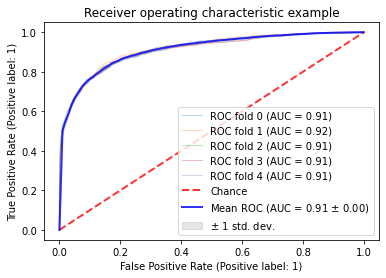

In [44]:
cv = StratifiedKFold(n_splits=5,random_state = 231,shuffle=True)
#classifier = svm.SVC( random_state=5)
#classifier = LogisticRegression(random_state=5)
#classifier = LogisticRegressionCV(random_state=5)
classifier = RandomForestClassifier(max_depth=20,n_estimators = 500, random_state=0,n_jobs=6)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X3, y3)):
  
    classifier.fit(X3[train], y3[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X3[test],
        y3[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()

In [45]:
set(y3)

{0, 1}

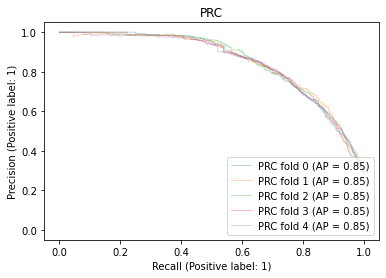

In [46]:
cv = StratifiedKFold(n_splits=5,random_state = 231,shuffle=True)
#classifier = svm.SVC( random_state=5)
#classifier = LogisticRegression(random_state=5)
#classifier = LogisticRegressionCV(random_state=5)
classifier = RandomForestClassifier(max_depth=20,n_estimators = 500, random_state=0,n_jobs=6)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X3, y3)):
    classifier.fit(X3[train], y3[train])
    viz = PrecisionRecallDisplay.from_estimator(
        classifier,
        X3[test],
        y3[test],
        name="PRC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    #interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    #interp_tpr[0] = 0.0
    #tprs.append(interp_tpr)
    #aucs.append(viz.roc_auc)



ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="PRC",
)
ax.legend(loc="lower right")
plt.show()

In [50]:
np.mean([0.85,0.85,0.85,0.85,0.85])

0.852

In [52]:
np.std([0.85,0.85,0.85,0.85,0.85])

0.0040000000000000036